Now that I've figured out morphing DR7 spectra, apply it to the much bigger DR14 sample where it will actually be useful.  Ideally in this notebook the larger training set from DR14 will lead to better reconstruction -- as well as more interpretable "latent parameters".

In [2]:
from tensorflow import keras
#import keras

from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import richardsplot
import os

In [3]:
np.__version__

'1.19.1'

In [4]:
(3121,)

(3121,)

In [5]:
import tensorflow as tf
tf.__version__

'1.12.0'

In [6]:
keras.__version__

'2.1.6-tf'

In [7]:
!ls ~/Desktop/Research/GTR/VLA2018b/DR14

DR14Q_v4_4.fits                download_rsync.txt
SDSSRM_11_Pix_Filter_Trevor.py dr14
VLA2018b_ICA_Spectra_dr14      dr14_plates.csv
VLA_spectraDR14_toICA.ipynb    plateMjdFiber_DR14Q.csv
__pycache__


In [8]:
#path = "/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/data/"
path = "/Users/trevormccaffrey/Desktop/Research/GTR/VLA2018b/"

In [9]:
#Load DR14 -- I have all the z~2 spectra on my machine
tab = Table.read(path+"DR14/DR14Q_v4_4.fits", format="fits")
dr14 = tab.to_pandas()
dr14.head()

SDSS_NAME        RA        DEC   THING_ID  PLATE    MJD  \
0  b'000000.45+174625.4'  0.001898  17.773739  268270422   7596  56945   
1  b'000000.57+055630.8'  0.002375   5.941903  163544156   8740  57367   
2  b'000000.66+145828.8'  0.002756  14.974675  244864389   6177  56268   
3  b'000000.97+044947.2'  0.004052   4.829781  154078229   4415  55831   
4  b'000001.20+240354.5'  0.005026  24.065163  319918739   7666  57339   

   FIBERID  SPECTRO        Z  Z_ERR  ...         JFLUX     JFLUX_ERR  \
0      162  b'BOSS'  2.30900    0.0  ...  0.000000e+00  0.000000e+00   
1      694  b'BOSS'  2.10312    0.0  ...  1.229889e-31  4.504542e-32   
2      595  b'BOSS'  2.49700    0.0  ...  2.310948e-31  4.565332e-32   
3      464  b'BOSS'  1.61900    0.0  ...  6.597500e-31  4.154652e-32   
4      121  b'BOSS'  1.61621    0.0  ...  0.000000e+00  0.000000e+00   

          HFLUX     HFLUX_ERR         KFLUX     KFLUX_ERR  FIRST_MATCHED  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             -1   
1  1.496425e-31  4.729050e-32  2.459819e-31  5.689572e-32              0   
2  2.355314e-31  5.970480e-32  2.427149e-31  6.521724e-32              0   
3  9.038160e-31  4.420332e-32  8.567425e-31  5.178768e-32              0   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             -1   

   FIRST_FLUX  FIRST_SNR  SDSS2FIRST_SEP  
0        -1.0       -1.0            -1.0  
1        -1.0       -1.0            -1.0  
2        -1.0       -1.0            -1.0  
3        -1.0       -1.0            -1.0  
4        -1.0       -1.0            -1.0  

[5 rows x 96 columns]

In [10]:
sdss_names = dr14[["SDSS_NAME"]].values.flatten()
z     = dr14[["Z"]].values.flatten()
plate = dr14[["PLATE"]].values.flatten()
mjd   = dr14[["MJD"]].values.flatten()
fiber = dr14[["FIBERID"]].values.flatten()
BAL   = dr14[["BI_CIV"]].values.flatten()!=0

This cell can take a while.

In [11]:
min(z), max(z)

(0.008517087, 6.9680266)

In [12]:
#How many dr14 quasars have CIV+CIII]+MgII?
((z>1.627)&(z<2.088)).sum()

92778

Plenty!-- and hopefully (probably?) a decent variety.

I thought I already had all these spectra downloaded, but that's another redshift range.  Download all DR14 spectra with $1.627<z<2.088$

Get the spectra

In [13]:
!ls ~/Desktop/Research/GTR/Cosmo/ML/data/CIV_to_MgII/lite/

0266  10000 2281  3849  4270  4610  4992  5373  5893  6290  6680  7164  7829
0267  1005  2282  3850  4271  4611  4993  5374  5894  6291  6681  7165  7830
0268  1006  2283  3851  4272  4612  4994  5375  5895  6292  6682  7166  7831
0269  1007  2284  3852  4273  4613  4995  5376  5896  6293  6683  7167  7832
0270  1059  2285  3853  4274  4614  4996  5377  5897  6294  6684  7168  7833
0387  1060  2286  3854  4275  4615  4997  5378  5898  6295  6685  7169  7834
0388  1061  2287  3855  4276  4616  4998  5379  5899  6296  6686  7183  7835
0389  1062  2288  3856  4277  4617  4999  5380  5900  6297  6687  7184  7836
0390  1063  2289  3857  4278  4618  5000  5381  5901  6298  6688  7235  7837
0391  1064  2290  3858  4279  4619  5001  5382  5902  6299  6689  7236  7838
0392  1065  2291  3859  4280  4620  5002  5383  5903  6300  6690  7237  7839
0393  1066  2292  3860  4281  4621  5003  5384  5904  6301  6691  7238  7840
0394  1067  2293  3861  4282  4622  5004  5385  5905  6302  6692  7275  7841

In [14]:
#Now we're working with dr14 only at 1.627 < z < 2.088, so use this new datafram from hereon
dat = pd.read_csv("~/Desktop/Research/GTR/Cosmo/ML/data/DR14_zmin162_zmax208.csv")
dat.head()

Unnamed: 0              SDSS_NAME        RA        DEC   THING_ID  PLATE  \
0          10  b'000001.56+203011.5'  0.006523  20.503197  290594773   7596   
1          19  b'000002.15+151516.6'  0.008980  15.254639  246765254   6172   
2          20  b'000002.19-021947.2'  0.009139  -2.329783   59825899   7850   
3          26  b'000002.97+225645.9'  0.012415  22.946096  311303506   7665   
4          28  b'000003.18+050822.3'  0.013254   5.139552  155964498   8740   

     MJD  FIBERID  SPECTRO         Z  ...         JFLUX     JFLUX_ERR  \
0  56945      821  b'BOSS'  2.083215  ...  0.000000e+00  0.000000e+00   
1  56269      394  b'BOSS'  1.710000  ...  2.910325e-31  4.694344e-32   
2  56956      339  b'BOSS'  1.966623  ...  0.000000e+00  0.000000e+00   
3  57328      452  b'BOSS'  1.759105  ...  0.000000e+00  0.000000e+00   
4  57367      340  b'BOSS'  1.801677  ...  1.431263e-31  4.114480e-32   

          HFLUX     HFLUX_ERR         KFLUX     KFLUX_ERR  FIRST_MATCHED  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             -1   
1  1.572201e-31  5.927228e-32  1.538285e-31  6.478741e-32             -1   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00              0   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             -1   
4  8.260369e-32  4.348945e-32  2.371781e-31  5.186590e-32              0   

   FIRST_FLUX  FIRST_SNR  SDSS2FIRST_SEP  
0        -1.0       -1.0            -1.0  
1        -1.0       -1.0            -1.0  
2        -1.0       -1.0            -1.0  
3        -1.0       -1.0            -1.0  
4        -1.0       -1.0            -1.0  

[5 rows x 97 columns]

In [15]:
sdss_names = dat[["SDSS_NAME"]].values.flatten()
z     = dat[["Z"]].values.flatten()
plate = dat[["PLATE"]].values.flatten()
mjd   = dat[["MJD"]].values.flatten()
fiber = dat[["FIBERID"]].values.flatten()
BAL   = dat[["BI_CIV"]].values.flatten()!=0

In [16]:
spec_path = "/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/data/CIV_to_MgII/lite/"

In [17]:
(plate==5429).sum()

11

In [18]:
#Want spectra with same wavelength range and number of pixels
N=0

for red, pl, mj, fib in zip(z, plate, mjd, fiber):
    try:
        hdul_spec = fits.open(spec_path+"%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        #print(spec_path+"%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    wavemask   = ((sdss_wave>=1443) & (sdss_wave<=2961))
    print(min(sdss_wave[wavemask]), max(sdss_wave[wavemask]), len(sdss_wave[wavemask]))
    N+=1
    if N>10: break

1443.099 2960.7131 3122
1443.2136 2960.9482 3122
1443.2365 2960.9949 3122
1443.2174 2960.9543 3122
1443.0518 2960.6162 3122
1443.1138 2960.7432 3122
1443.1283 2960.7715 3122
1443.225 2960.9697 3122
1443.1111 2960.736 3122
1443.1958 2960.9097 3122
1443.2692 2960.3794 3121


In [19]:
3790 / (1+1.625), 3790 / (1+2.1), 9150 / (1+1.65), 9150 / (1+2.09)

(1443.8095238095239,
 1222.5806451612902,
 3452.8301886792456,
 2961.1650485436894)

In [20]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
names   = []
spectra = []
wave    = []
ivar    = []
found   = [] #save dataframe indices which have spectra
BAL_list= []
N = 0

for sdss_name, red, pl, mj, fib, bal in zip(sdss_names, z, plate, mjd, fiber, BAL):
    try:
        hdul_spec = fits.open(spec_path+"%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        #print(spec_path+"%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>=1443) & (sdss_wave<=2961))
    sdss_flux  = sdss_flux[wavemask]
    #sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()
    
    if len(sdss_flux) >= 3121:
        names.append(sdss_name)
        spectra.append(sdss_flux[:3121])
        wave.append(sdss_wave[:3121])
        ivar.append(sdss_ivar[:3121])
        found.append(N)
        if bal: BAL_list.append(bal)

    N+=1
    if N%5000==0: print(N)  
    if N>100: break
    
spectra = np.array(spectra)
wave    = np.array(wave)
ivar    = np.array(ivar)
found = np.array(found)

----

Now that all spectra are loaded in the desired format, set up the morphing.  See ``autoencoder4_morphing.ipynb`` for how the reference array was obtained.

In [21]:
spectra.shape

(101, 3121)

In [22]:
#Get the normed data
morph_norm = np.load("/Users/trevormccaffrey/Desktop/git/Cosmology_Quasars/morph_ref_DR7mean_normed.npy")
spectra_normed = spectra / np.median(spectra, axis=1)[:, np.newaxis]
spectra_normed.shape

(101, 3121)

We'll use this "baby NN" (trained on DR7 spectra) to get reconstructions which will provide the "general shapes" of the spectra which we can then morph; the actual quality of the reconstructions is not much of a concern right now.

In [23]:
#Create the preliminary reconstructions to determine morphing; using reconstructions ignores absorption (mostly)
import tensorflow.keras.backend as K
MASKK= (~((wave[0]>1490)&(wave[0]<1546))).astype(int) #Mask CIV absorption
MASK = K.variable(MASKK)

#Build the encoder - the dimension of the final layer is the dimension of the latent space
morph_encoder = keras.models.Sequential([
    keras.layers.Lambda(lambda x: x*MASK, input_shape=[3121]), #this layer is the mask - turn off corresponding neurons
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal")
])

#Build the decoder - given values in latent space, it will reconstruct the original spectrum
morph_decoder = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer="he_normal", input_shape=[6]),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(3121) #no activation function since we want actual pixel values
])

morph_encoder.load_weights("/Users/trevormccaffrey/Desktop/git/Cosmology_Quasars/autoencoders/autoencoder3_enc.h5")
morph_decoder.load_weights("/Users/trevormccaffrey/Desktop/git/Cosmology_Quasars/autoencoders/autoencoder3_dec.h5")

morph_ae = keras.models.Sequential([morph_encoder, morph_decoder])

spec_norm_reconst_prelim = morph_ae.predict(spectra_normed)

In [24]:
#fit a continuum

markers = {
    1: wave[0][5],
    2: 1690,
    3: 2200,
    4: 2660,
    5: 2915,
    6: wave[0][-5]
}

def continuum(wave, spec, markers):
    cont_region = {}

    for i in range(len(markers)-1):
        ind1 = abs(wave-markers[i+1]).argmin()
        ind2 = abs(wave-markers[i+1+1]).argmin()
        fit_region = np.polyfit([np.median(wave[(ind1-5):(ind1+5)]), np.median(wave[(ind2-5):(ind2+5)])], 
                                [np.median(spec[(ind1-5):(ind1+5)]), np.median(spec[(ind2-5):(ind2+5)])], 
                                 1) #do a linear fit on this section
    
        if i==0:
            x = wave[:ind2]
        elif i==(len(markers)-2):
            x = wave[ind1:]
        else:
            x = wave[ind1:ind2]
        y = fit_region[0]*x + fit_region[1]
        cont_region[i] = [x, y]

    return np.concatenate((cont_region[0][1], cont_region[1][1], cont_region[2][1], cont_region[3][1],
                           cont_region[4][1]))

Make some example plots -- is the morphing working as we expect?

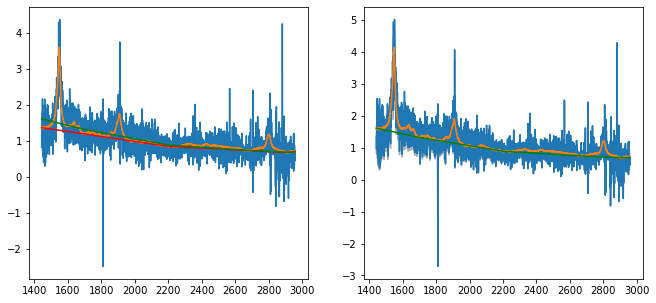

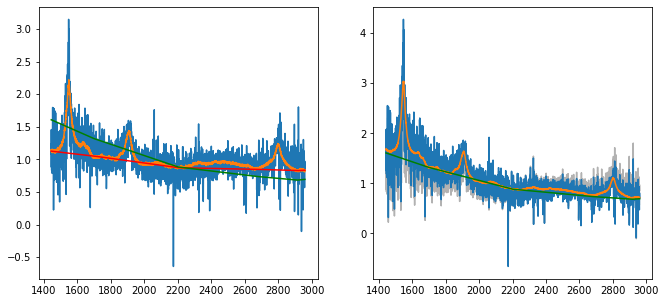

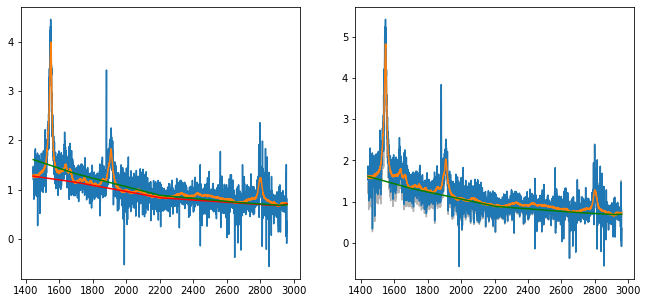

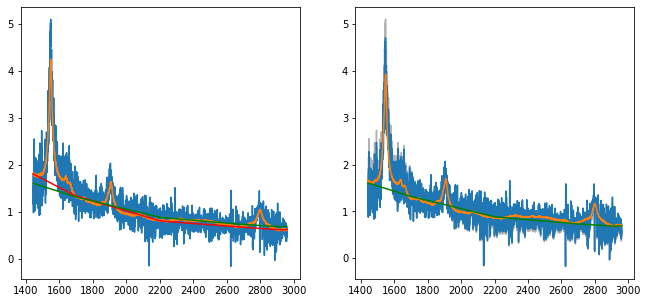

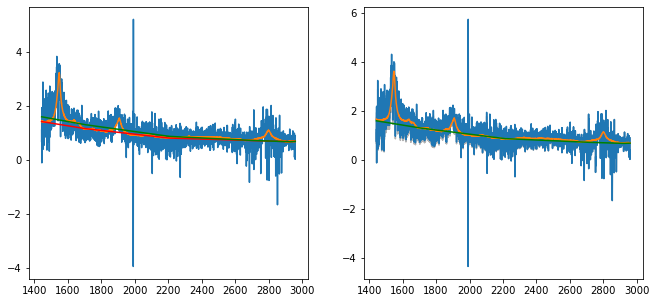

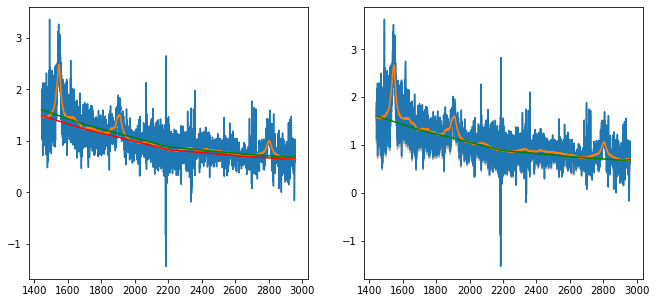

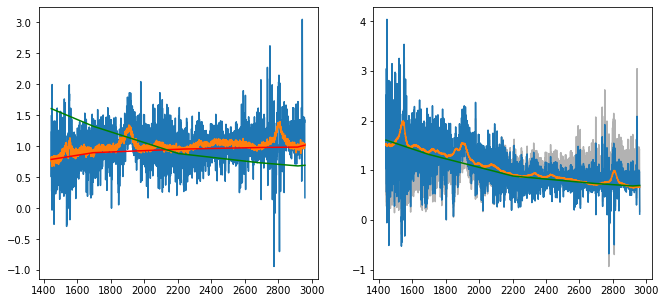

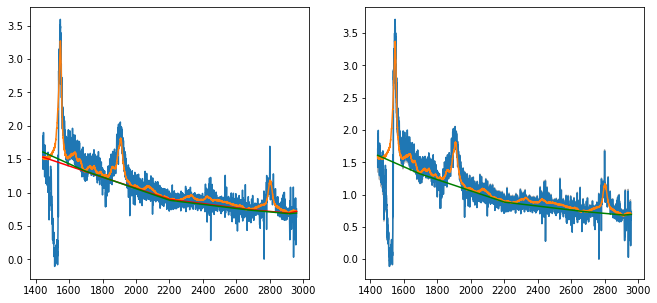

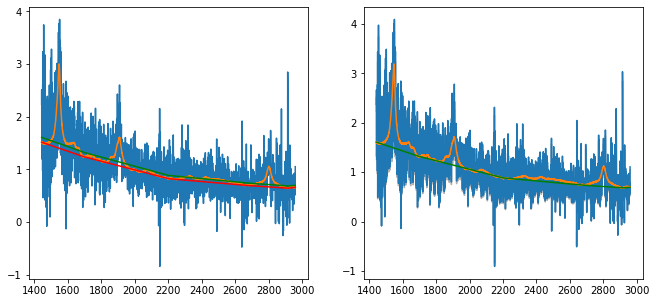

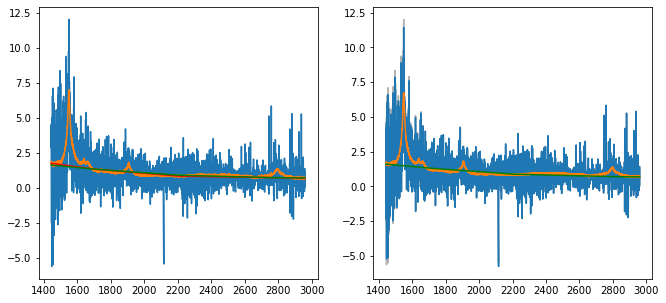

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


LinAlgError: SVD did not converge in Linear Least Squares

In [25]:
for i in range(100):
    cont = continuum(wave[i], spec_norm_reconst_prelim[i], markers) #get reconstruction-based reconstruction
    morph_coeff = morph_norm / cont 
    spec_morphed = spectra_normed[i] * morph_coeff
    #specrec_morphed = spec_norm_reconst_prelim[i] * morph_coeff
    #print(spec_morphed.shape)
    specrec_morphed = morph_ae.predict(np.array([spec_morphed])).flatten()
    
    
    
    ax2.plot(wave[i], spectra_normed[i], color="black", alpha=0.3)
    ax2.plot(wave[i], spec_morphed)
    ax2.plot(wave[i], specrec_morphed)
    ax2.plot(wave[i], morph_norm, "g")
    
    plt.show()

Great, it looks like the morphing is working and is actually helping quite a bit (will be more obvious with DR14 spectra).  Now build a new autoencoder based entirely on morphed spectra.

Load morphed spectra into their own array:

In [174]:
def morph(wave, spectrum, spectrum_reconst, markers):
    cont = continuum(wave, spectrum_reconst, markers) #get reconstruction-based reconstruction
    morph_coeff = morph_norm / cont 
    return spectrum * morph_coeff

spectra_morphed = []

for i in range(len(spectra)):
    spec_morphed = morph(wave[i], spectra_normed[i], spec_norm_reconst_prelim[i], markers)
    spectra_morphed.append(spec_morphed)
    
spectra_morphed = np.array(spectra_morphed)
spectra_morphed

array([[1.7252128 , 1.7617524 , 1.5957476 , ..., 0.7780792 , 0.6979609 ,
        0.74164665],
       [1.6663337 , 1.7432215 , 1.6806492 , ..., 0.65048057, 0.7126602 ,
        0.5976808 ],
       [1.311188  , 1.3494418 , 1.5846375 , ..., 0.7336755 , 0.71493334,
        0.7003319 ],
       ...,
       [1.4929816 , 1.4744081 , 1.4732546 , ..., 0.75840145, 0.6364291 ,
        0.63492125],
       [0.546731  , 1.1392787 , 1.7542334 , ..., 0.7748927 , 0.59847605,
        0.99668   ],
       [1.3803701 , 1.6846263 , 1.4053302 , ..., 0.6437797 , 0.92607003,
        0.62825006]], dtype=float32)

In [177]:
import tensorflow.keras.backend as K

In [179]:
#Mask CIV absorption
n_latent = 6
MASKK= (~((wave[0]>1490)&(wave[0]<1546))).astype(int) #Mask CIV absorption - might want to shorten red end
MASK = K.variable(MASKK)

In [181]:
#Build the encoder - the dimension of the final layer is the dimension of the latent space
stacked_encoder = keras.models.Sequential([
    keras.layers.Lambda(lambda x: x*MASK, input_shape=spectra[0].shape), #this layer is the mask - turn off corresponding neurons
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(n_latent, kernel_initializer="he_normal")
])

#Build the decoder - given values in latent space, it will reconstruct the original spectrum
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer="he_normal", input_shape=[n_latent]),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    #keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(spectra[0].shape[0]) #no activation function since we want actual pixel values
])

#Now put them together
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

Now need to compile our model.  The two main ingredients will be the loss function we choose, and the optimizer.  Keep it simple for now, and just see what happens with mean square error and stochastic gradient descent.

In [204]:
stacked_ae.compile(loss="logcosh", optimizer=keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999))

In [205]:
X_train = spectra_morphed[:5000]
X_valid = spectra_morphed[5000:7000]
X_test  = spectra_morphed[7000:]

#X_train will be both the "input" (to the encoder) and the "target" (of the decoder) for the autoencoder
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Train on 5000 samples, validate on 2000 samples
Epoch 1/20
5000/5000 [==============================] - 4s 787us/step - loss: 0.0097 - val_loss: 0.0091
Epoch 2/20
5000/5000 [==============================] - 3s 586us/step - loss: 0.0097 - val_loss: 0.0091
Epoch 3/20
5000/5000 [==============================] - 3s 588us/step - loss: 0.0097 - val_loss: 0.0091
Epoch 4/20
5000/5000 [==============================] - 3s 591us/step - loss: 0.0097 - val_loss: 0.0091
Epoch 5/20
5000/5000 [==============================] - 3s 582us/step - loss: 0.0097 - val_loss: 0.0091
Epoch 6/20
5000/5000 [==============================] - 3s 584us/step - loss: 0.0097 - val_loss: 0.0091
Epoch 7/20
5000/5000 [==============================] - 3s 581us/step - loss: 0.0097 - val_loss: 0.0091
Epoch 8/20
5000/5000 [==============================] - 3s 590us/step - loss: 0.0097 - val_loss: 0.0091
Epoch 9/20
5000/5000 [==============================] - 3s 616us/step - loss: 0.0097 - val_loss: 0.0091
Epoch 10/20
5000

In [206]:
X_train.shape

(5000, 3121)

Note: This wasn't the only round of training.  Want to start with higher learning rate then slowly decrease.

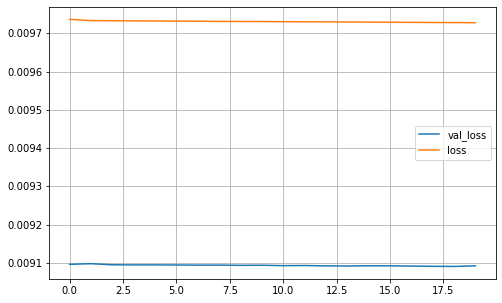

In [207]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [210]:
reconst = stacked_ae.predict(np.array([X_test[0]]))

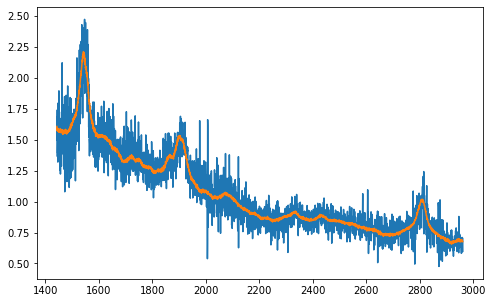

In [211]:
fig = plt.figure(figsize=(8,5))

#plt.plot(wave[800], spectra[800])
plt.plot(wave[6000], X_valid[0])
plt.plot(wave[6000], reconst[0])
plt.show()

In [212]:
n_spectra = 100
reconst = stacked_ae.predict(np.array(X_test[:n_spectra]))

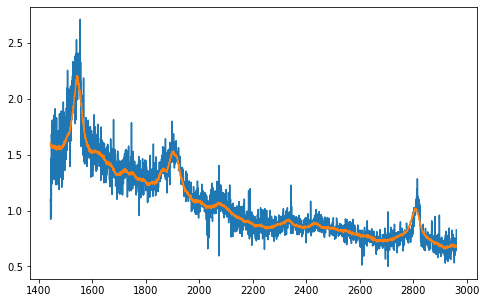

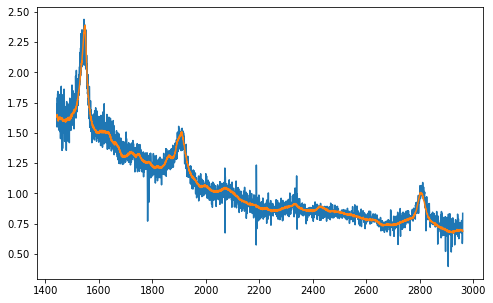

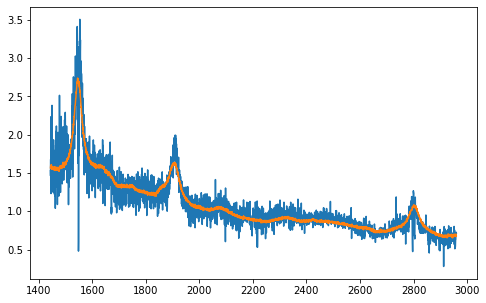

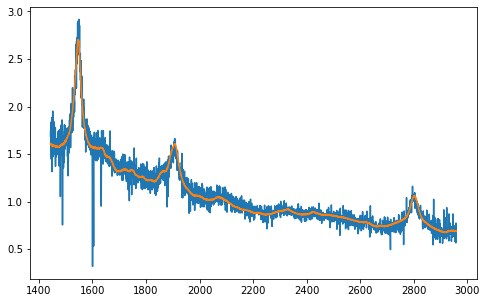

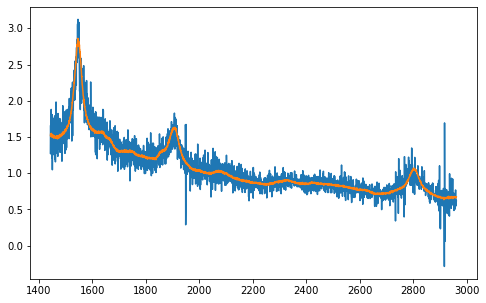

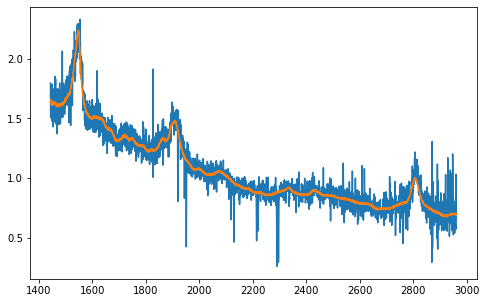

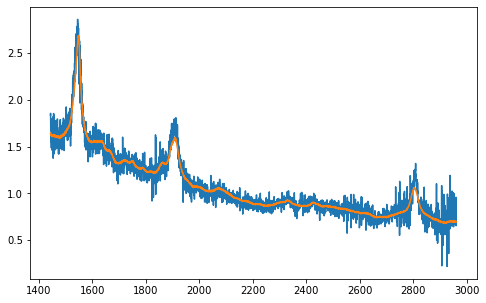

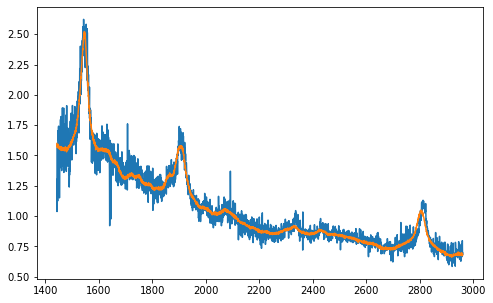

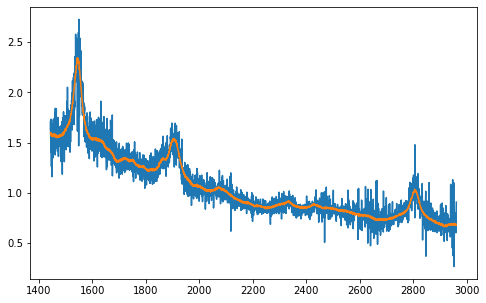

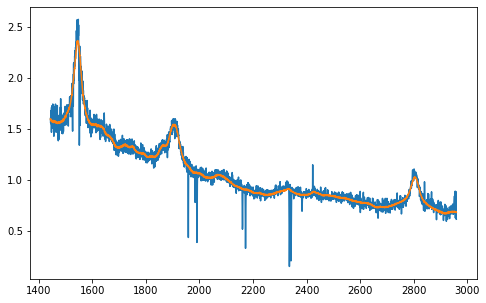

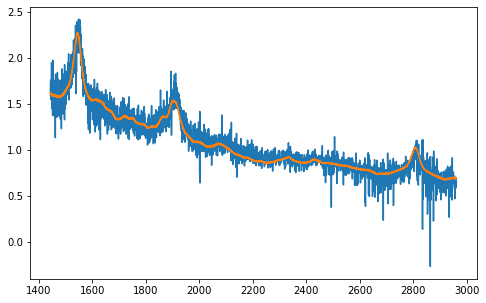

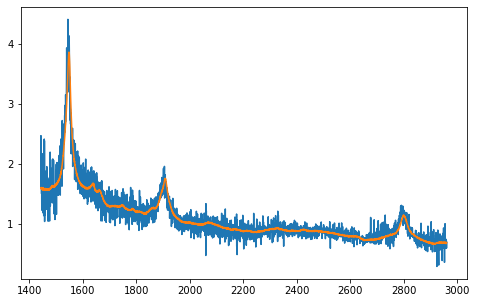

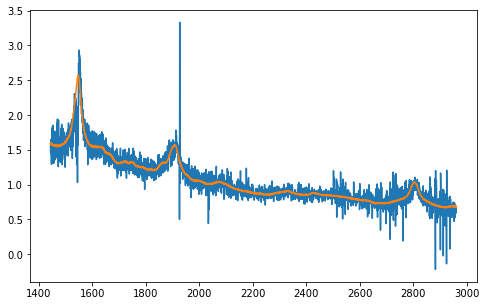

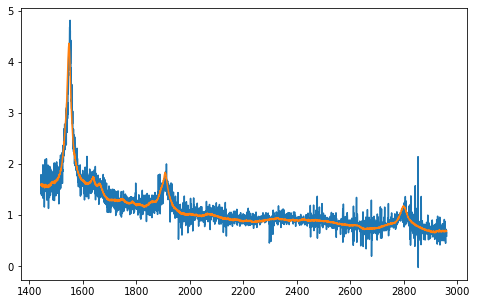

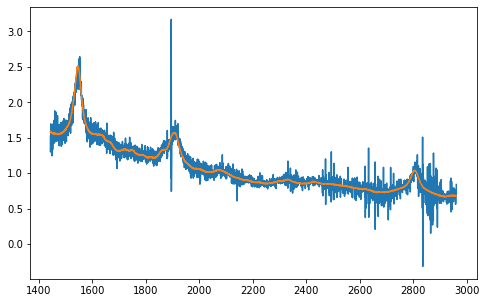

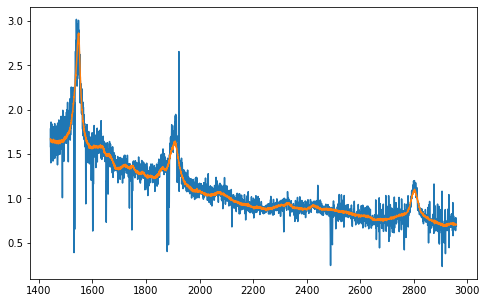

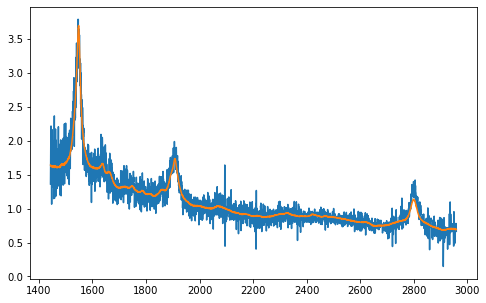

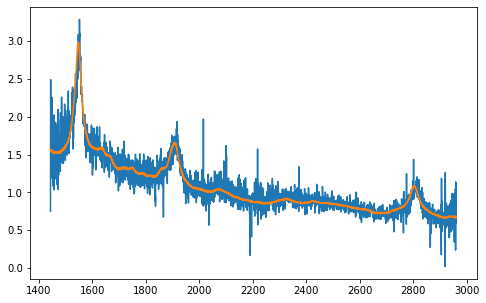

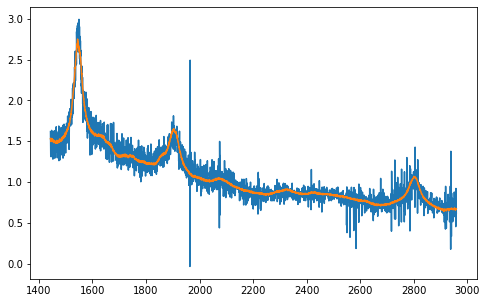

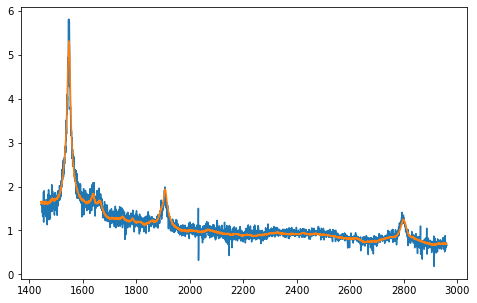

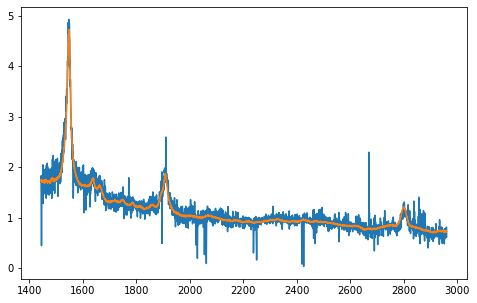

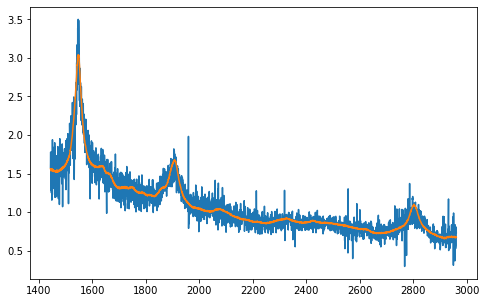

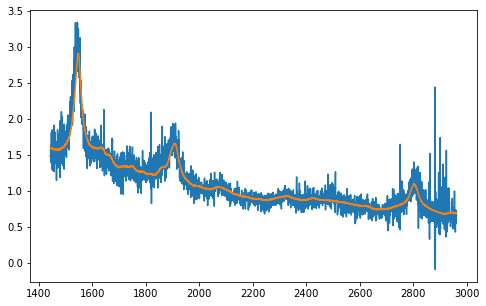

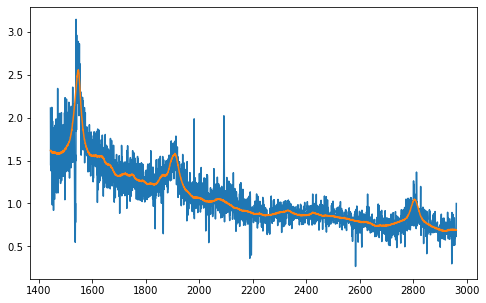

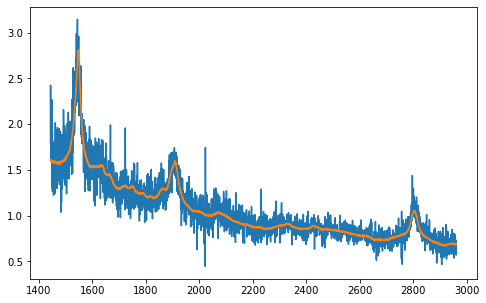

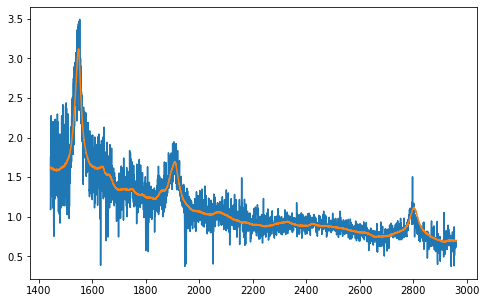

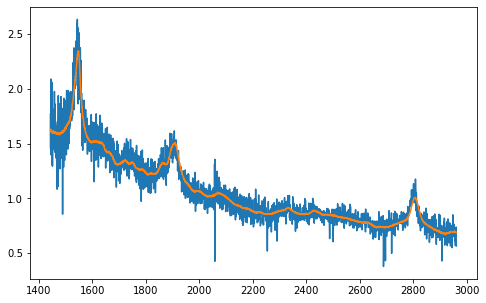

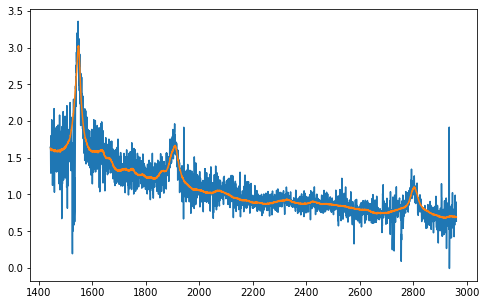

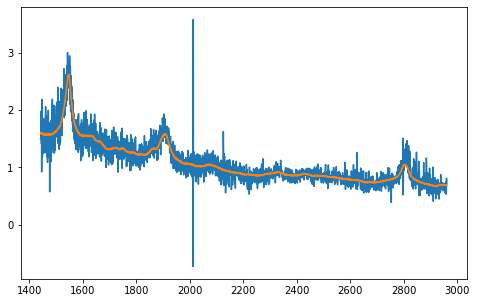

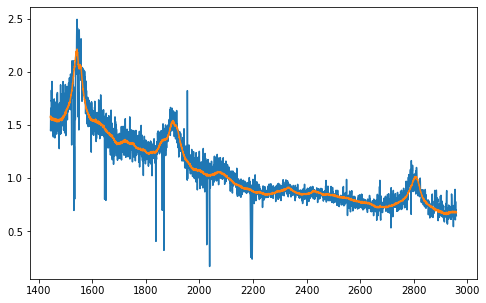

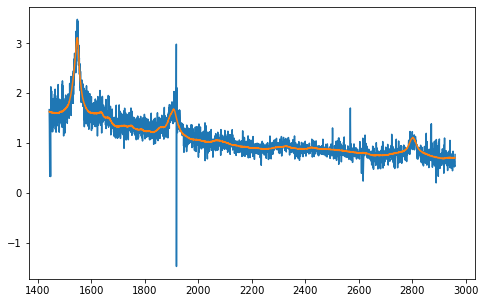

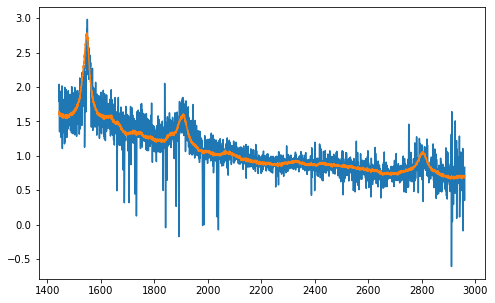

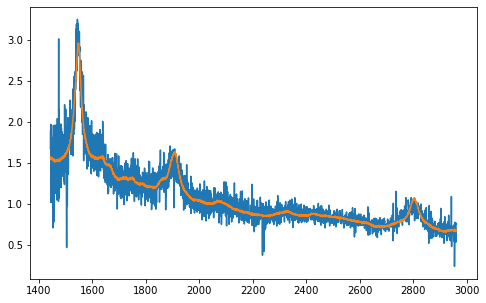

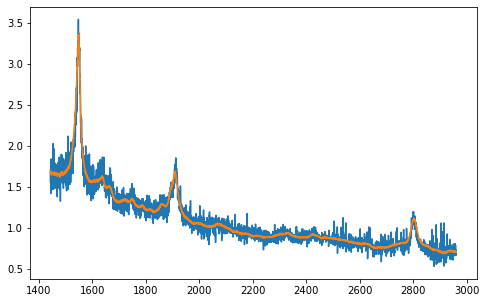

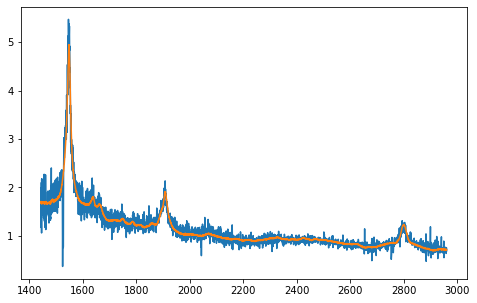

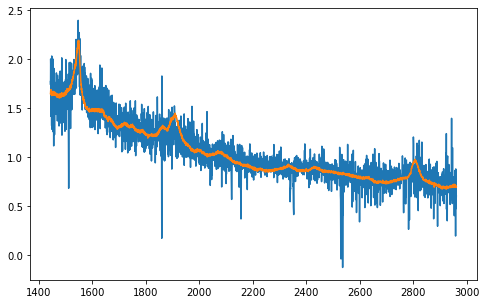

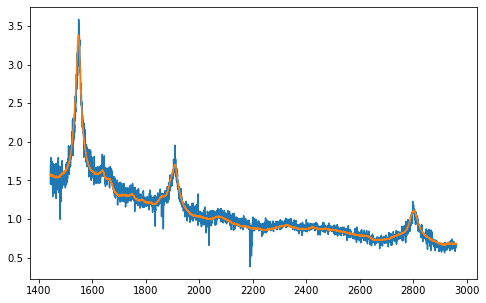

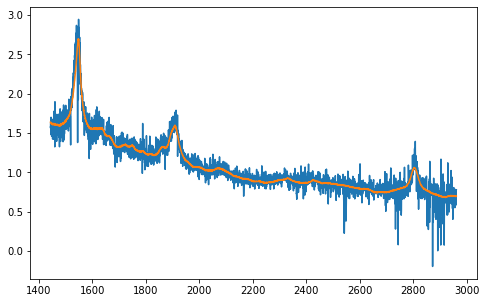

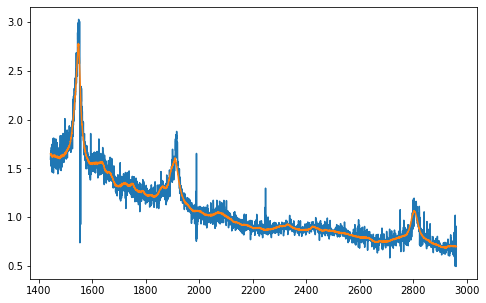

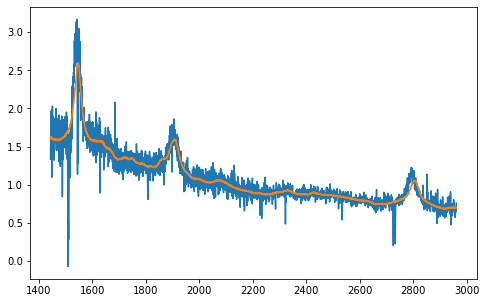

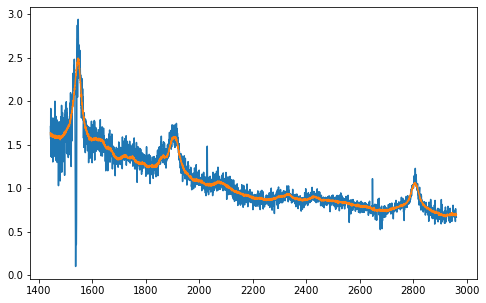

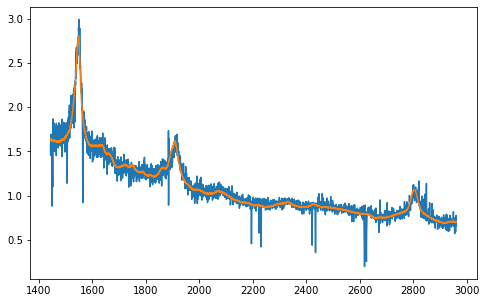

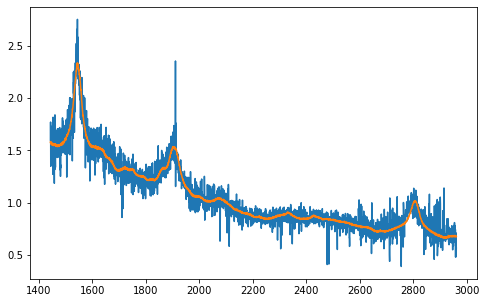

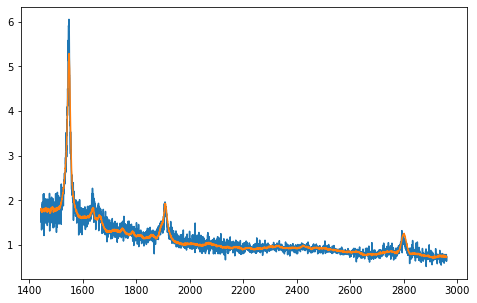

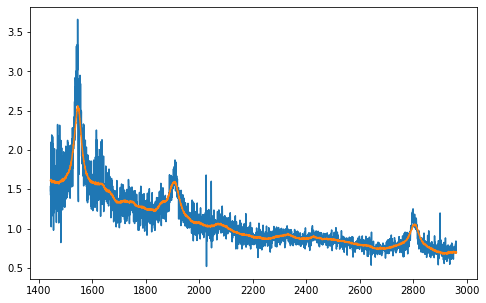

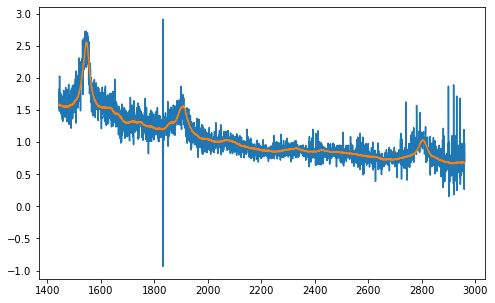

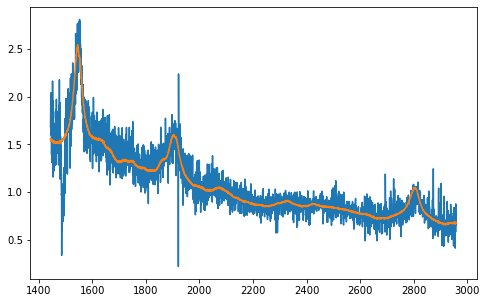

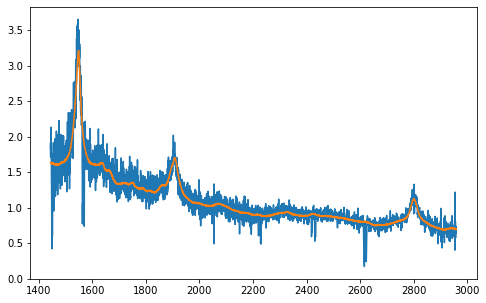

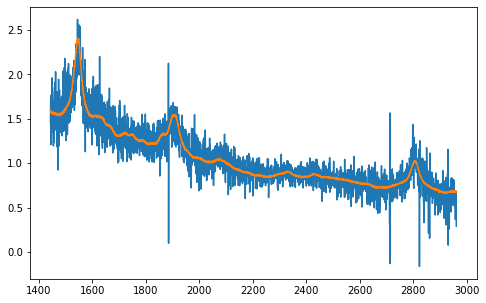

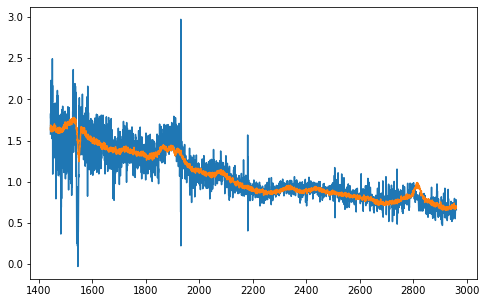

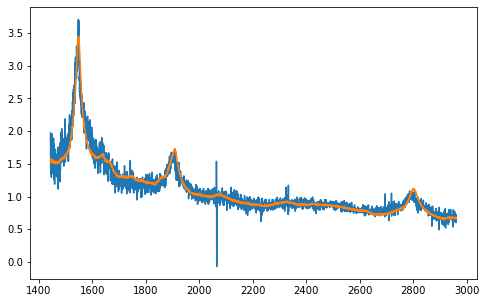

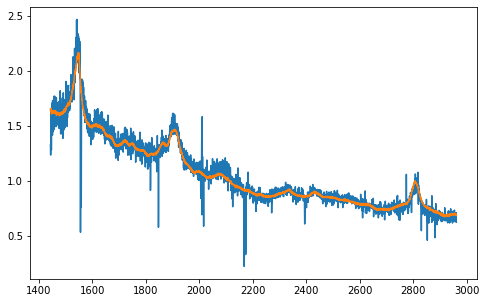

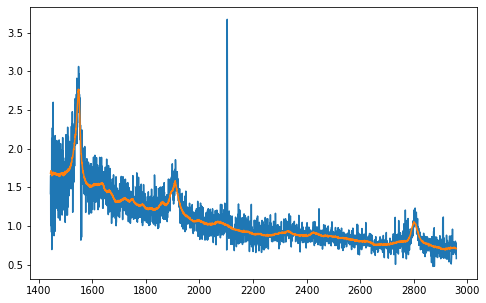

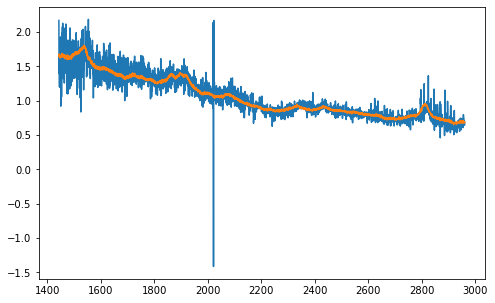

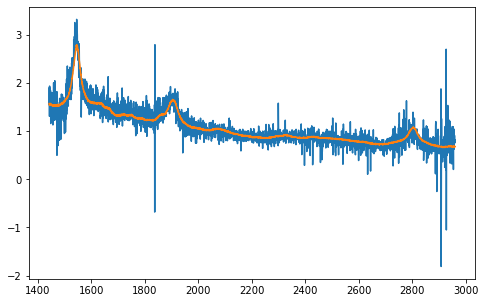

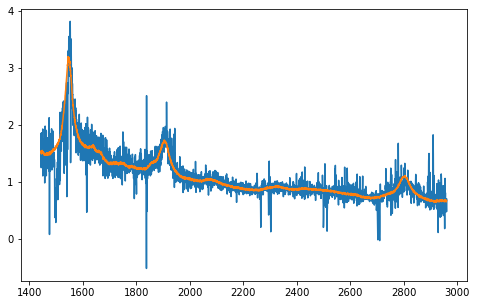

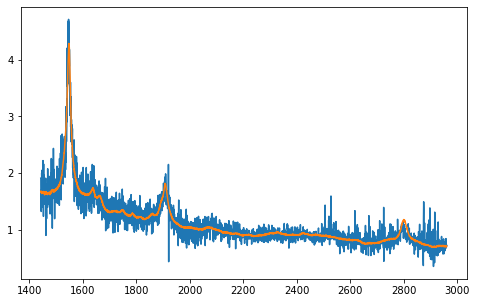

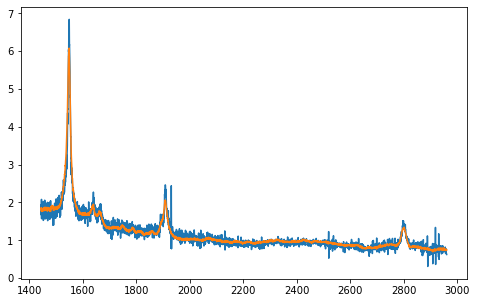

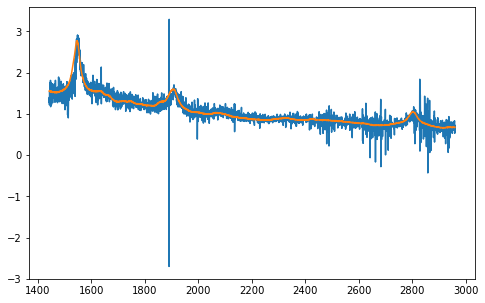

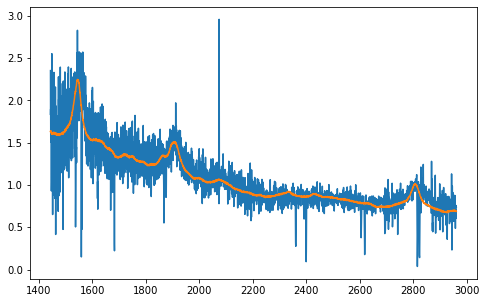

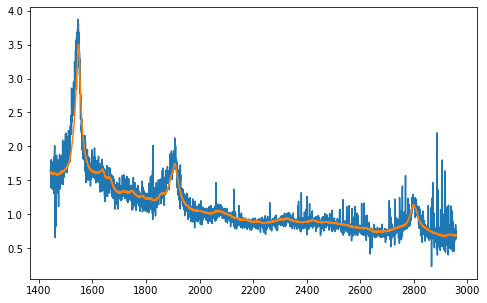

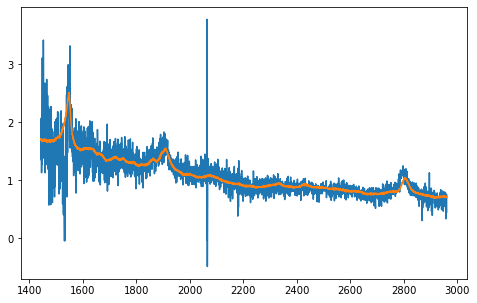

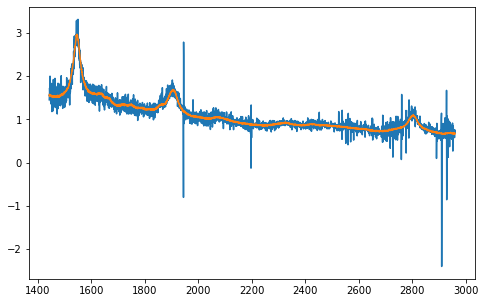

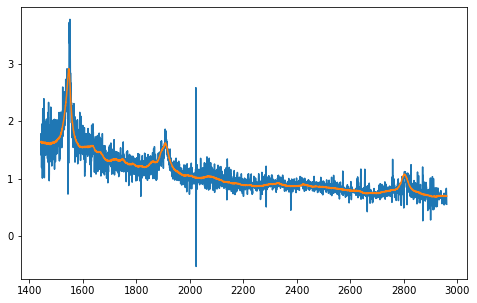

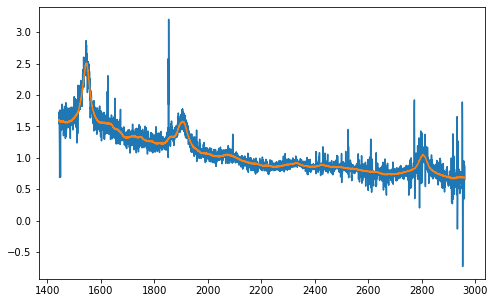

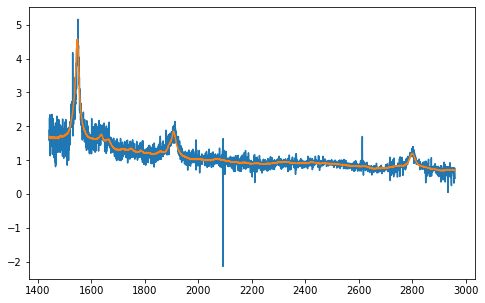

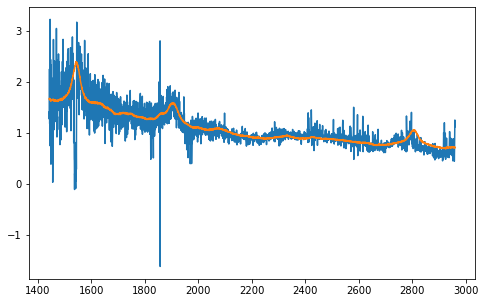

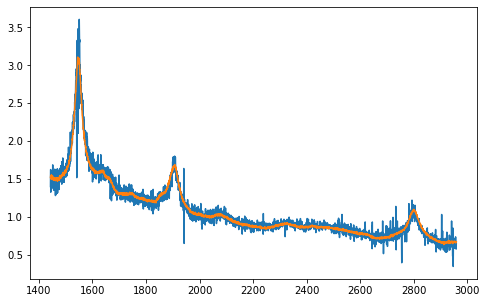

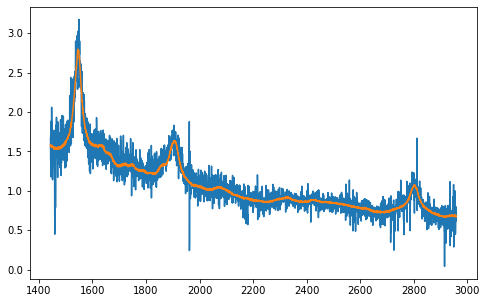

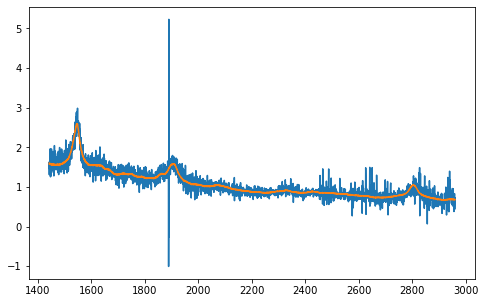

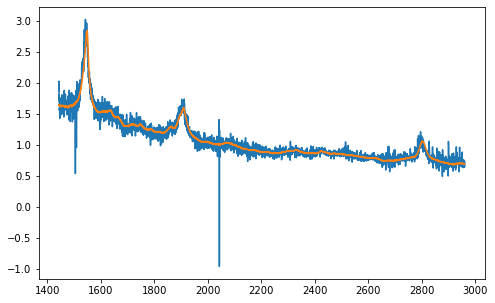

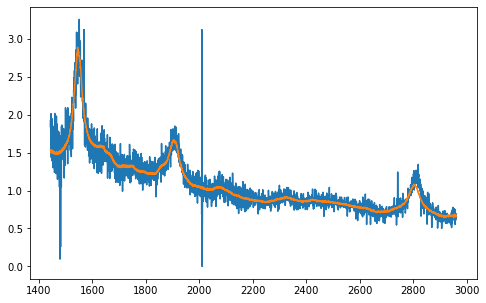

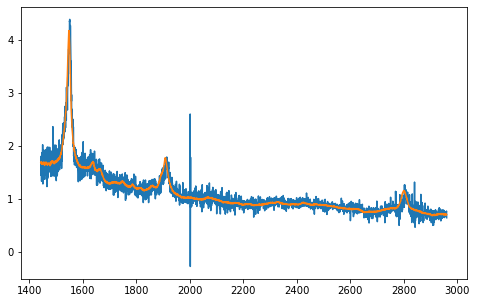

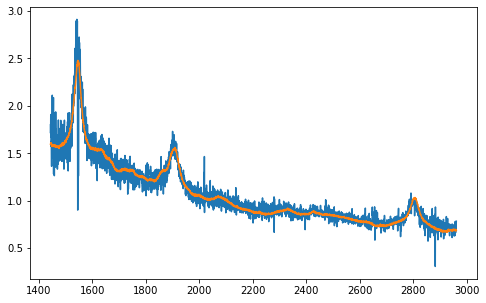

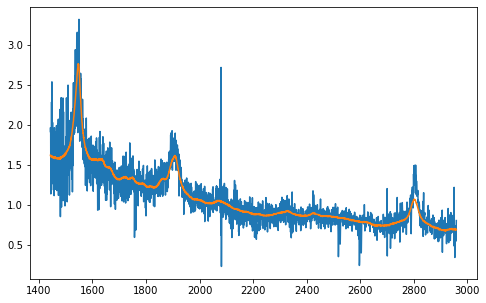

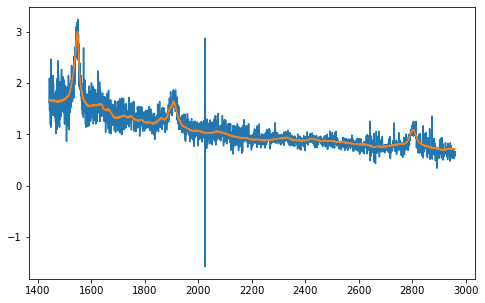

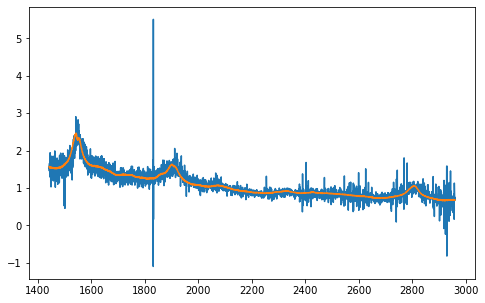

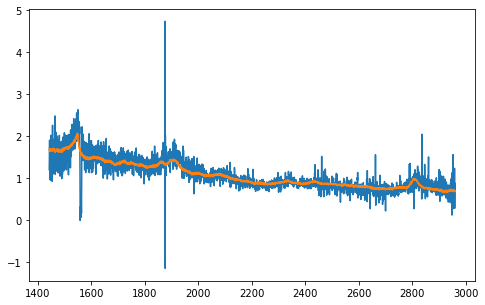

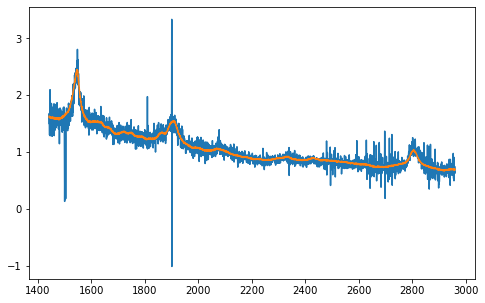

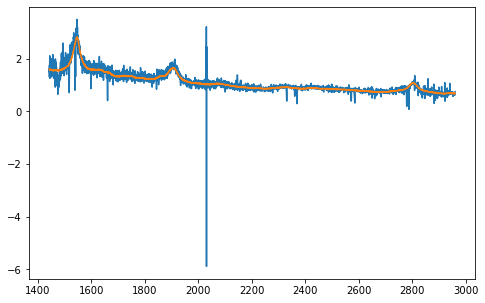

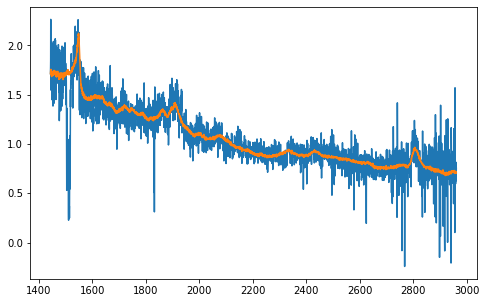

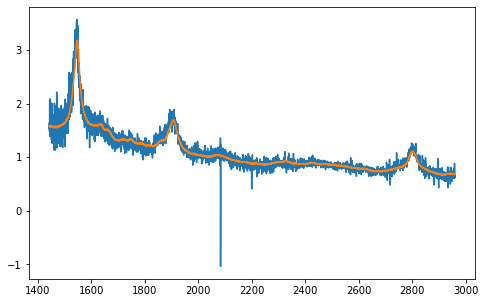

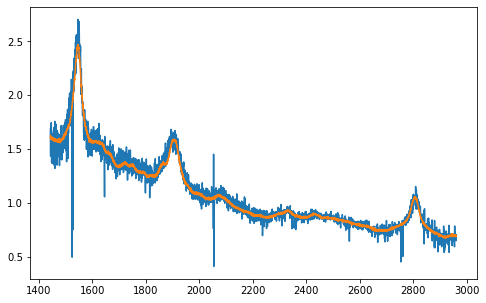

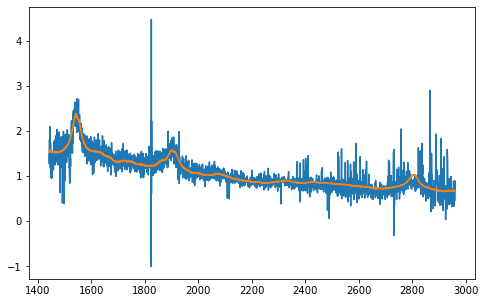

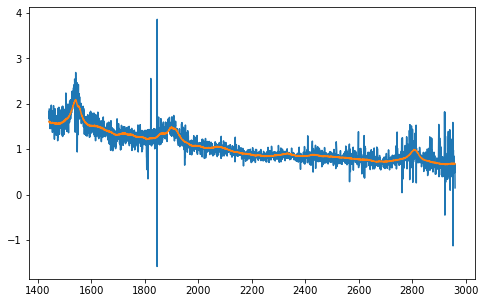

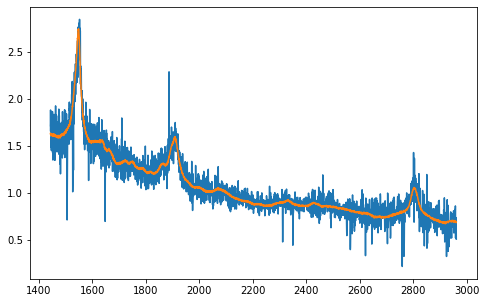

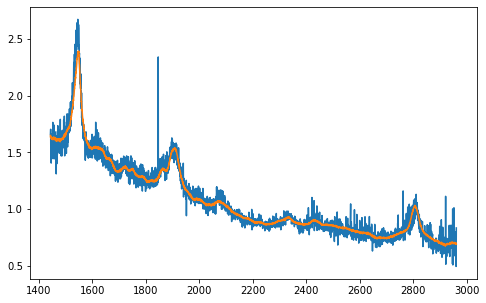

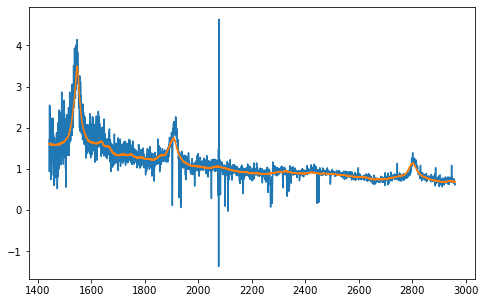

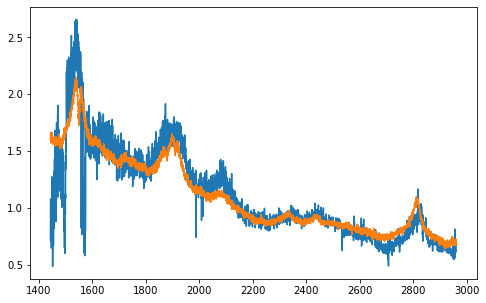

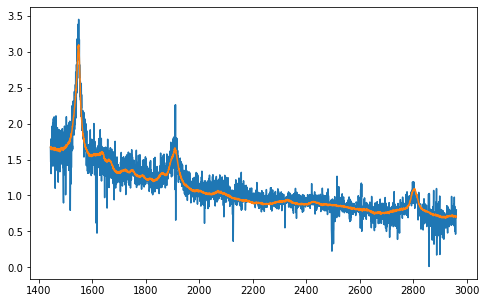

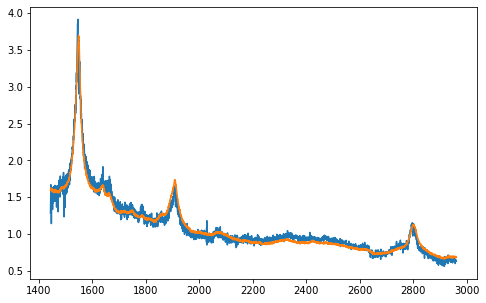

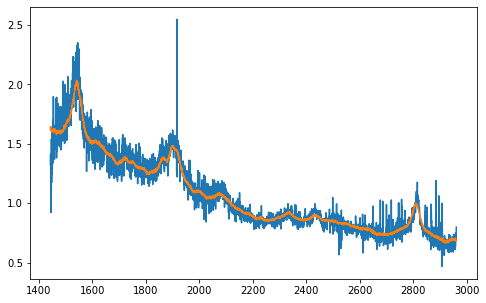

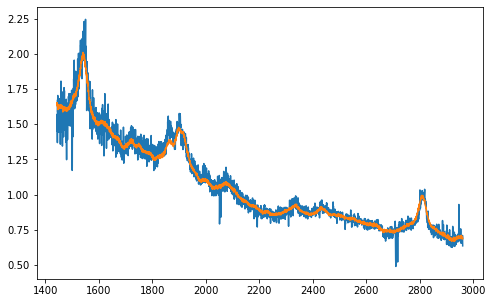

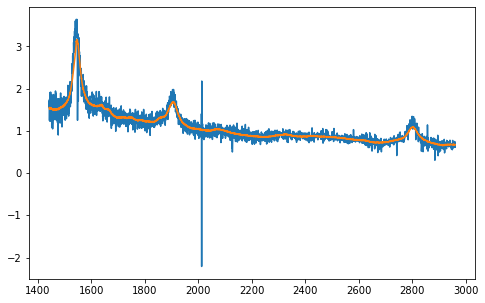

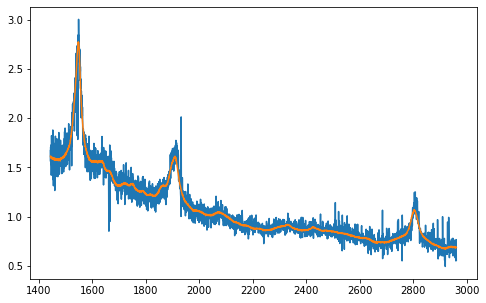

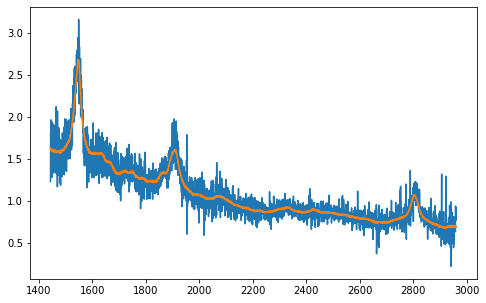

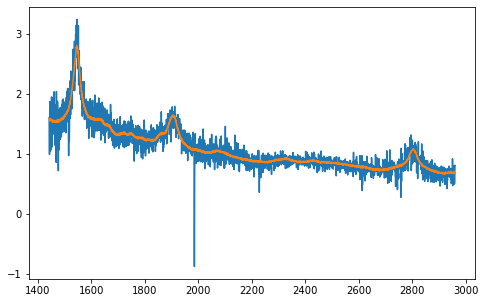

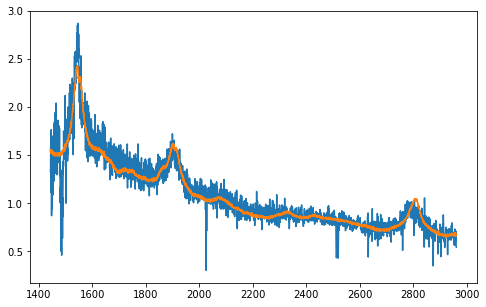

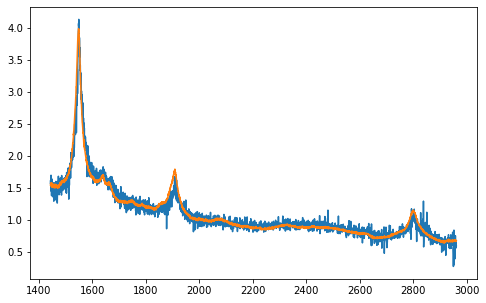

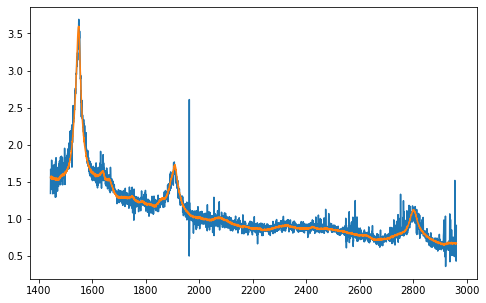

In [213]:
for i in range(n_spectra):
    #reconst = stacked_ae.predict(np.array([X_valid[i]]))
    fig = plt.figure(figsize=(8,5))
    plt.plot(wave[6000+i], X_test[i])
    plt.plot(wave[6000+i], reconst[i])
    plt.show()

Generally pretty good, but definitely weak in some areas.  Stronger emission lines (CIII] and MgII) it seems to struggle with; odd that it seems to sometimes get those spectra right though.  Maybe move to DR14 and get some more spectra now; hopefully more training data will help with some issues.

``Adam`` is definitely the optimizer to use.

In [214]:
X = np.vstack([X_train, X_valid, X_test])
X.shape

(8368, 3121)

In [215]:
#Compress the spectra down to 10 dimensions
X_compressed = stacked_encoder.predict(X)

In [216]:
X_compressed.shape

(8368, 6)

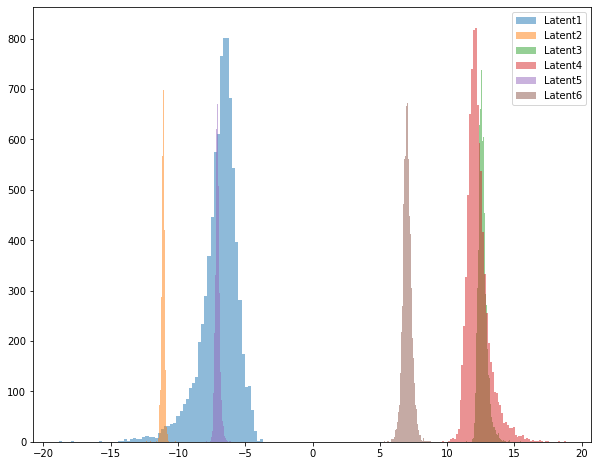

In [218]:
fig = plt.figure(figsize=(10,8))
for i in range(X_compressed.shape[1]):
    _ = plt.hist(X_compressed[:,i],bins='scott', alpha=0.5, label="Latent{}".format(i+1))
plt.legend(loc="best")
plt.show()

Note: The SeLU activation function leads to saturation at ~-1.75 for four of the latent parameters; use leaky ReLU to get nice distributions like above.

In [219]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,learning_rate=150)
projTSNE2 = tsne.fit_transform(X_compressed)

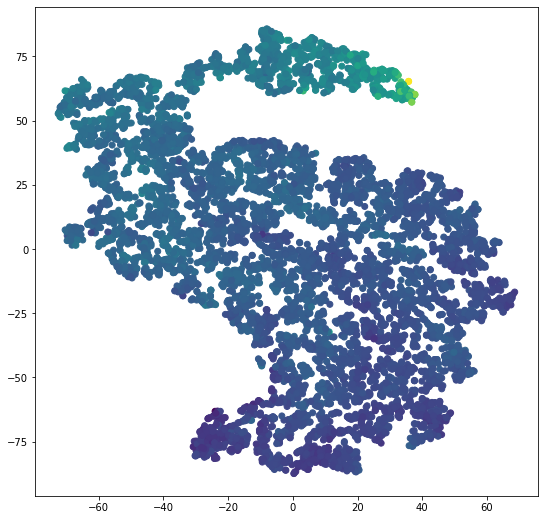

In [220]:
fig = plt.figure(figsize=(9,9))

plt.scatter(projTSNE2[:,0], projTSNE2[:,1], c=X_compressed[:,2])
plt.show()

Interesting... 

Now want to see what exactly each latent parameter represents.  Since we're dealing with 10 parameters, the space created by them is essentially a 10-dimensional hypersphere.  We can track the change caused by one parameter by holding the rest constant (at their median), and changing the value of the given latent parameter incrementally.  Then, after the increment, feed the latent parameters to the decoder and see what information it holds.

One strange (troublesome?) thing is that certain parameters change much more than others, but maybe I should just be running PCA to see which ones to throw out??  (That is, for visualization of just the parameters-- we still need them to reconstruct the spectrum because the decoder needs all)

In [221]:
X_compressed

array([[ -6.656836 , -11.196295 ,  12.583553 ,  12.162502 ,  -7.0870404,
          6.898917 ],
       [ -6.275068 , -11.077759 ,  12.378908 ,  11.746117 ,  -7.091307 ,
          7.0208435],
       [ -8.555177 , -11.231456 ,  12.935916 ,  13.086589 ,  -6.9049   ,
          7.0327306],
       ...,
       [ -7.0527987, -11.102357 ,  12.60188  ,  12.107822 ,  -7.0011106,
          7.3842196],
       [ -5.6756124, -11.140435 ,  12.463808 ,  11.644338 ,  -7.3640156,
          7.089056 ],
       [ -7.062914 , -11.012358 ,  12.600688 ,  12.305864 ,  -6.9967084,
          7.0698347]], dtype=float32)

In [222]:
np.median(X_compressed, axis=0)

array([ -6.708341, -11.096823,  12.590092,  12.159277,  -7.075781,
         7.014802], dtype=float32)

In [223]:
def blueshift(wave_half_flux):
    return ((1549.48 - wave_half_flux) / 1549.48) * 3e5

CIV EW = 24.98 Å, CIV Blueshift = 581.67 km/s


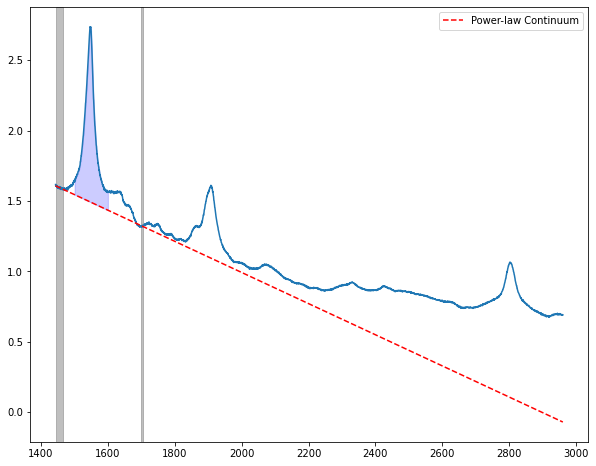

In [227]:
test = stacked_decoder.predict(np.array([np.median(X_compressed, axis=0)]))
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(wave[0], test[0])
#ax.plot([1549.48,1549.48], [10, 27], "--k", label="Laboratory Wavelength - CIV")
#plt.xscale("log")

#Find the blueshift
CIV = (wave[0]>1465)&(wave[0]<1650)
civ_peak = wave[0][CIV][test[0][CIV].argmax()]
#ax.plot([civ_peak,civ_peak], [10, 27], "--", label="Measured Wavelength - CIV")
#print(((1549.48-civ_peak)/1549.48)*3e5, "km/s")


#Fit continuum
cont1 = ((wave[0]>=1445)&(wave[0]<=1465))
cont2 = ((wave[0]>=1700)&(wave[0]<=1705))
ax.axvspan(1445, 1465, alpha=0.5, color='grey')
ax.axvspan(1700, 1705, alpha=0.5, color='grey')


m,b = np.polyfit(np.concatenate((wave[0][cont1], wave[0][cont2])), np.concatenate((test[0][cont1], test[0][cont2])), 1)
continuum = wave[0]*m + b
plt.plot(wave[0], continuum, "--r", label="Power-law Continuum")\

#Plot EW to compute
EW = ((wave[0]>=1500)&(wave[0]<=1600))
ax.fill_between(wave[0][EW], 
                continuum[EW],
                test[0][EW], color="blue", alpha=0.2)

#And compute the EW
CIV_EW = 0
ew_list = [0.]
for i in range(len(wave[0][EW])):
    try:
        CIV_EW += ( (test[0][EW][i] - continuum[i]) / continuum[i] ) * ( wave[0][EW][i+1] - wave[0][EW][i] )
    except IndexError:
        CIV_EW += ( (test[0][EW][i] - continuum[i]) / continuum[i] ) * ( wave[0][EW][i] - wave[0][EW][i-1] )
        
    ew_list.append(CIV_EW)
        
        
ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()

print("CIV EW = %.2f Å, CIV Blueshift = %.2f km/s" % (CIV_EW, blueshift(wave[0][EW][ind_half_flux])))

plt.legend(loc="best")
plt.show()

In [228]:
def get_latent(X_comp, n, n_versions):
    #remove comments to plot - but this causes problems since noisy spectra are at extrema,
    #so just return spectra and choose which to plot
    
    #fig = plt.figure(figsize=(12,10))
    
    predictions = np.array([])
    
    #Set bounds to traverse when plotting differences
    low, high = np.min(X_comp[:,n]), min(np.max(X_comp[:,n]), 400)
    
    #get the median for all other values
    median = np.median(X_comp, axis=0)
    #median_other = np.delete(X_comp, n)
    
    #loop through min-->max and get corresponding spectra
    for i in np.linspace(low, high, n_versions): #maybe sample from logspace here instead?
        latent_params = median.copy()
        latent_params[n] = i
        predict = stacked_decoder.predict(np.array([latent_params]))
        
        if len(predictions) > 0:
            predictions = np.vstack([predictions, predict])
        else:
            predictions = np.append(predictions, predict)
        
        #plt.plot(wave[0], predict[0], alpha=0.6)
        
        
    #plt.show()
    
    return predictions

In [229]:
n_diff = 12
prediction = np.array([[]])

predict1 = get_latent(X_compressed, 0, n_diff)
predict2 = get_latent(X_compressed, 1, n_diff)
predict3 = get_latent(X_compressed, 2, n_diff)
predict4 = get_latent(X_compressed, 3, n_diff)
predict5 = get_latent(X_compressed, 4, n_diff)
predict6 = get_latent(X_compressed, 5, n_diff)
#predict7 = get_latent(X_compressed, 6, n_diff)
#predict8 = get_latent(X_compressed, 7, n_diff)
#predict9 = get_latent(X_compressed, 8, n_diff)
#predict10= get_latent(X_compressed, 9, n_diff)

In [230]:
predict1[0]

array([1.16095603, 0.76348734, 0.78220445, ..., 0.7286281 , 0.68972617,
       0.25041473])

In [231]:
def plot_latent(prediction, omit=0, reverse=True):
    fig = plt.figure(figsize=(12,10))
    if reverse:
        for i in range(prediction.shape[0]-1-omit, -1, -1):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    else:
        for i in range(prediction.shape[0]-omit):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    plt.legend(loc="best")
    plt.show()

#### Param1

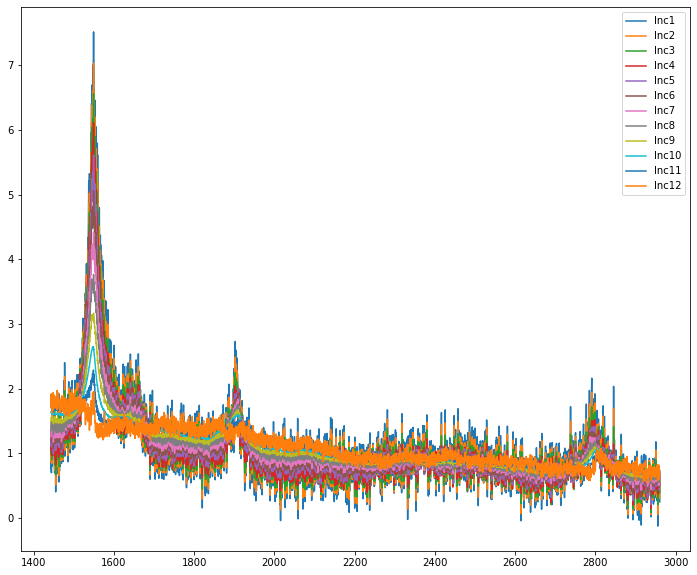

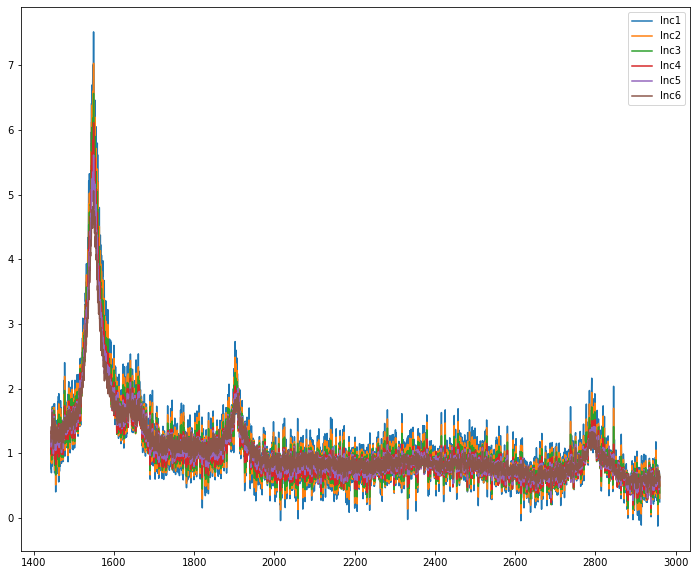

In [284]:
plot_latent(predict1, reverse=False)
plot_latent(predict1, omit=6,  reverse=False)

#### Param2

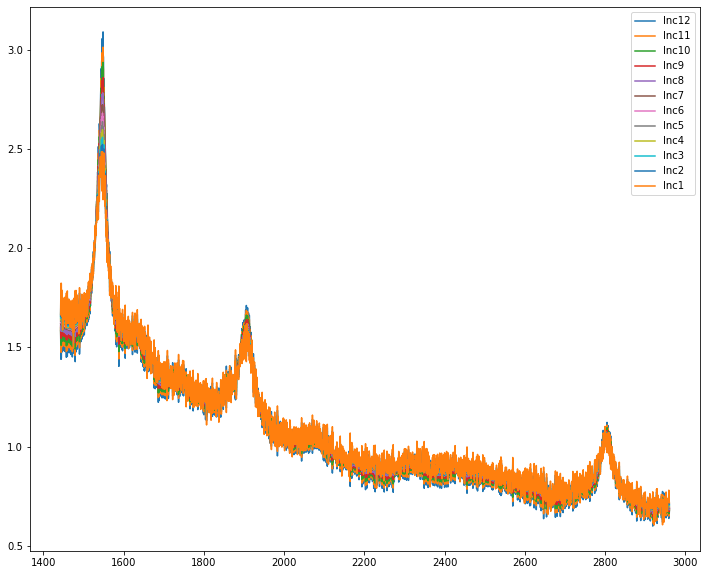

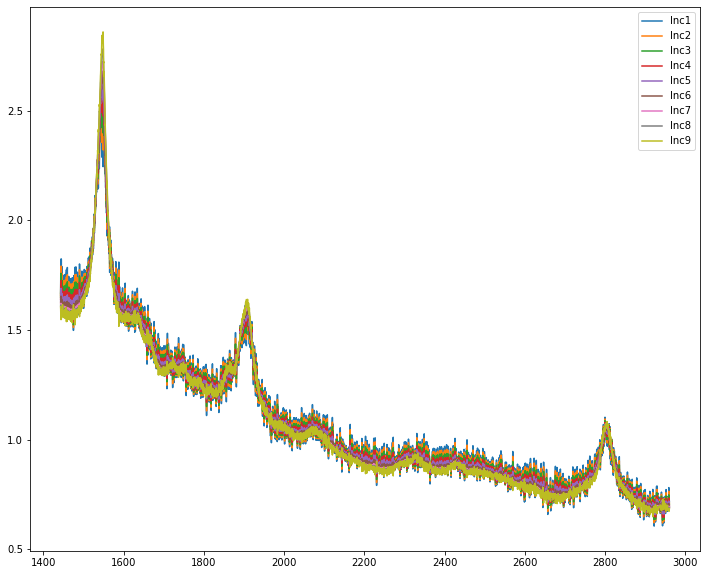

In [233]:
plot_latent(predict2)
plot_latent(predict2, omit=3, reverse=False)

#### Param3

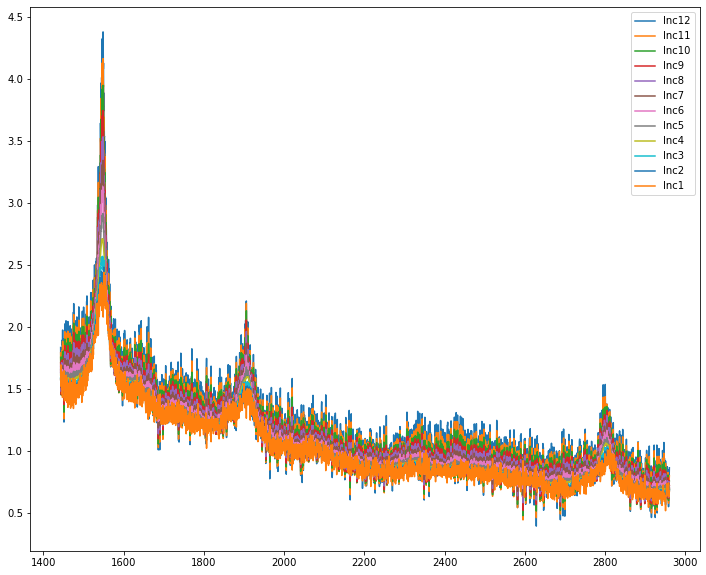

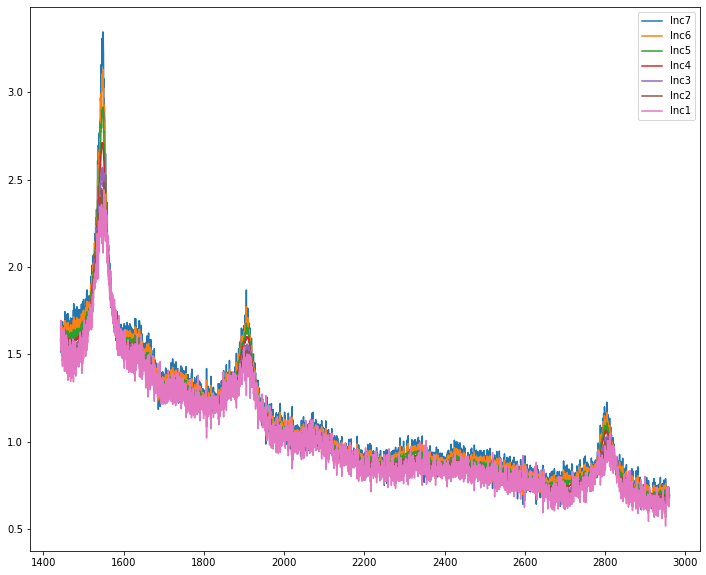

In [238]:
plot_latent(predict3, reverse=True)
plot_latent(predict3, omit=5, reverse=True)


#### Param4

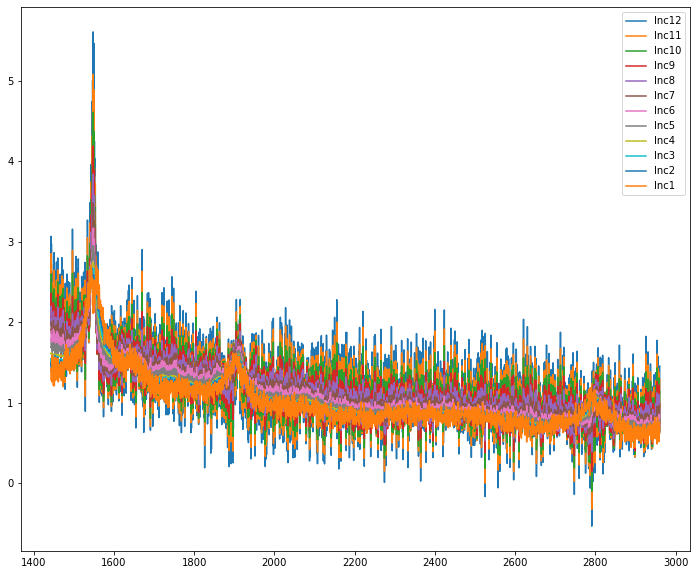

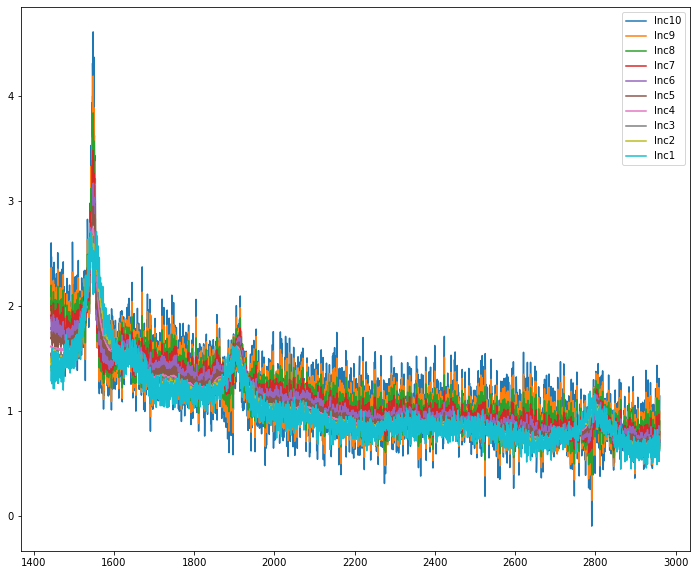

In [239]:
plot_latent(predict4, reverse=True)
plot_latent(predict4, omit=2, reverse=True)

Higher vals tend towards CIV BAL, noisier spectrum

#### Param5

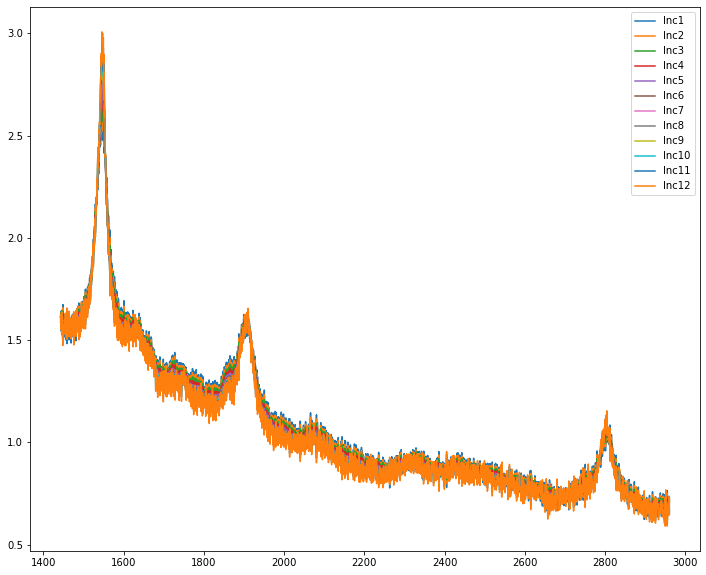

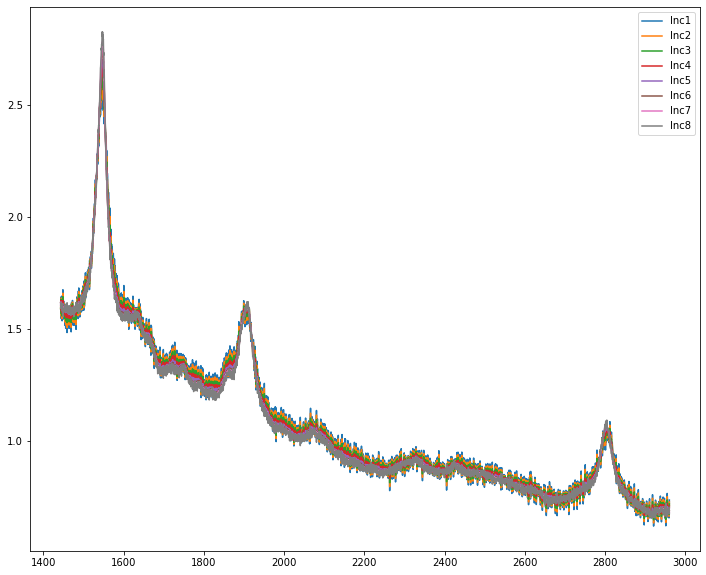

In [236]:
plot_latent(predict5, reverse=False)
plot_latent(predict5, omit=4, reverse=False)

#### Param6

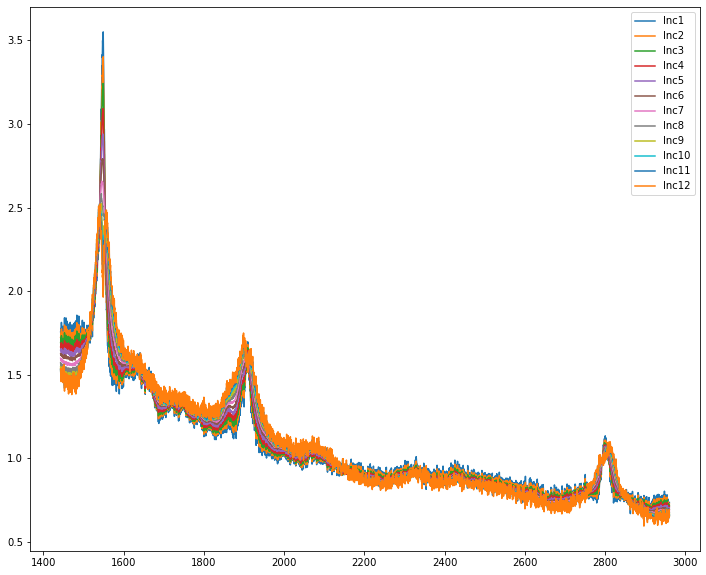

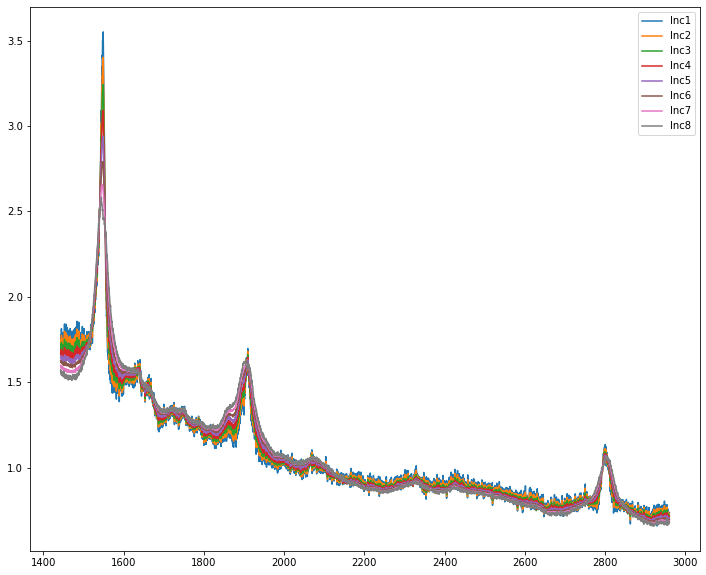

In [237]:
plot_latent(predict6, reverse=False)
plot_latent(predict6, omit=4, reverse=False)

In [90]:
def plotTSNE(colorcode, mask, lab=""):
    fig = plt.figure(figsize=(9,9))
    plt.scatter(projTSNE2[:,0], projTSNE2[:,1], c=colorcode, vmin=np.percentile(colorcode, 15), 
                vmax=np.percentile(colorcode, 85), label=lab)
    plt.colorbar()
    plt.legend(loc="best")
    plt.show()

In [91]:
dat.head()

name        RA_1     Dec_1  REDSHIFT_1  PLATE_1  FIBER_1  \
0  095004.94-002012.2  147.520612 -0.336744      1.7756      267      275   
1  095938.28-003500.8  149.909527 -0.583571      1.8766      268       59   
2  101033.44-004724.5  152.639355 -0.790145      1.6675      270      213   
3  101100.92+002039.4  152.753859  0.344291      1.7487      270      491   
4  101826.85-000951.1  154.611911 -0.164201      1.8156      271      152   

   MJD_1  UNIFORM_TARGET_1    MI_Z2_1  LOGLBOL_1  ...  LOGEDD_RATIO_2  \
0  51608                 0 -27.635967  47.094489  ...       -0.494012   
1  51633                 0 -26.986037  46.849020  ...       -0.837157   
2  51909                 0 -27.539811  47.031922  ...       -0.780922   
3  51909                 0 -26.907112  46.713170  ...       -0.337591   
4  51883                 0 -27.177639  46.782514  ...       -0.564674   

   SPECIAL_INTEREST_FLAG    Z_HW_2  Z_HW_ERR  \
0                      0  1.779394  0.001750   
1                      0  1.882529  0.002026   
2                      0  1.668503  0.001680   
3                      0  1.750491  0.001797   
4                      0  1.823599  0.001849   

                                               UGRIZ  \
0  (18.360000610351562, 18.19099998474121, 18.083...   
1  (19.43400001525879, 18.878000259399414, 18.794...   
2  (18.4060001373291, 18.243999481201172, 18.0189...   
3  (18.82699966430664, 18.69700050354004, 18.6709...   
4  (18.757999420166016, 18.59600067138672, 18.552...   

                                           UGRIZ_ERR  \
0  (0.017999999225139618, 0.014000000432133675, 0...   
1  (0.08100000023841858, 0.020999999716877937, 0....   
2  (0.020999999716877937, 0.014000000432133675, 0...   
3  (0.024000000208616257, 0.017999999225139618, 0...   
4  (0.019999999552965164, 0.017999999225139618, 0...   

                                         UGRIZ_DERED  DELTA_G_I    E_BV_2  \
0  (18.001000612974167, 17.926775991916656, 17.89...  -0.037049  0.069739   
1  (19.252000018954277, 18.74404826760292, 18.696...  -0.060394  0.035407   
2  (18.178000137209892, 18.07619148492813, 17.897...   0.209583  0.044319   
3  (18.662999659776688, 18.576296500861645, 18.58...  -0.121854  0.031931   
4  (18.50699943304062, 18.411264687776566, 18.418...  -0.134676  0.048818   

   Separation  
0    0.009446  
1    0.013102  
2    0.012673  
3    0.005305  
4    0.010948  

[5 rows x 65 columns]

In [92]:
len(found)

8368

In [94]:
dat[["LOGLBOL_1"]].values.flatten()

array([47.09448912, 46.8490198 , 47.03192224, ..., 47.08738135,
       46.77145762, 46.43468484])

In [451]:
np.percentile(dat[["LOGLBOL_1"]].values.flatten(), 15)

46.588360133665574

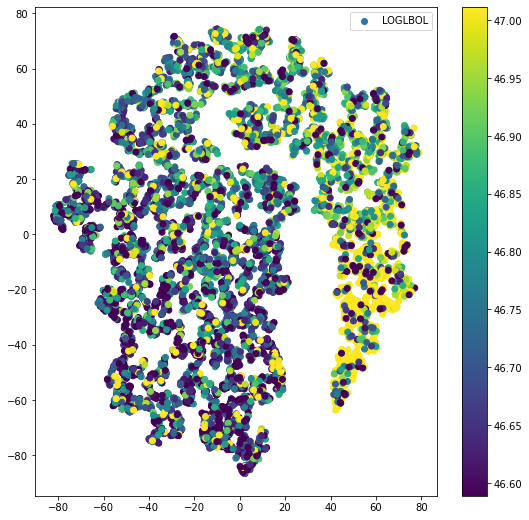

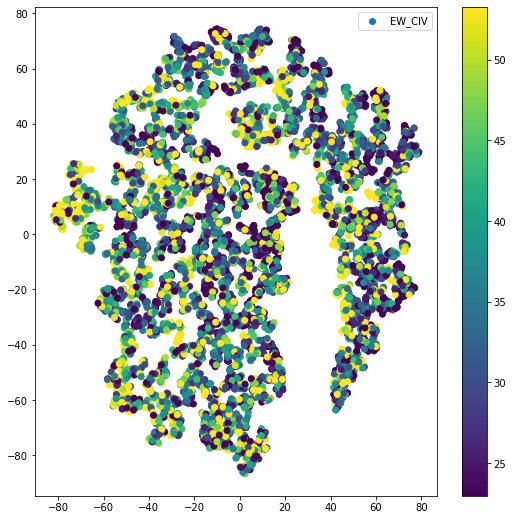

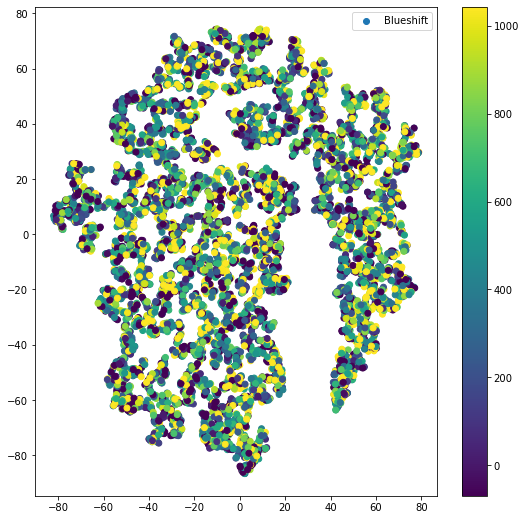

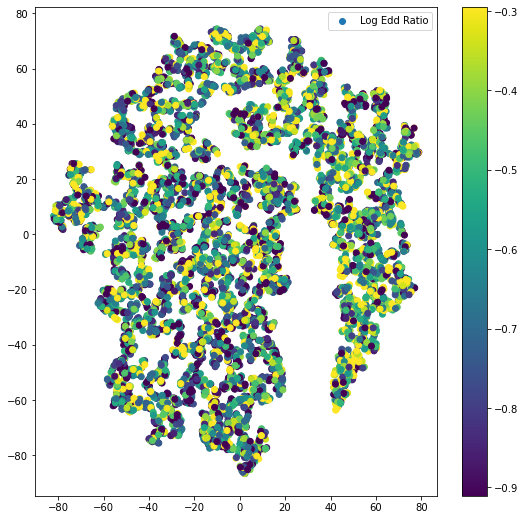

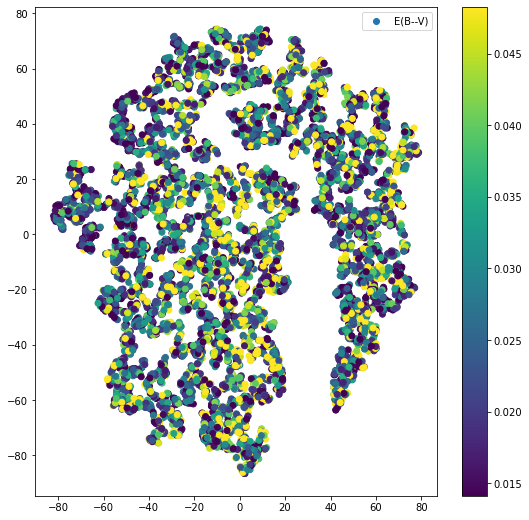

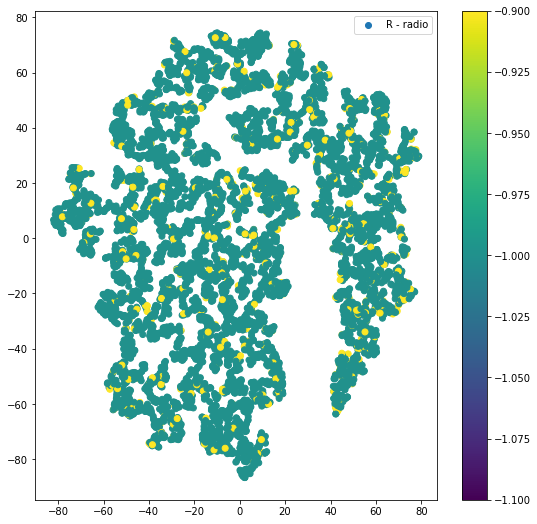

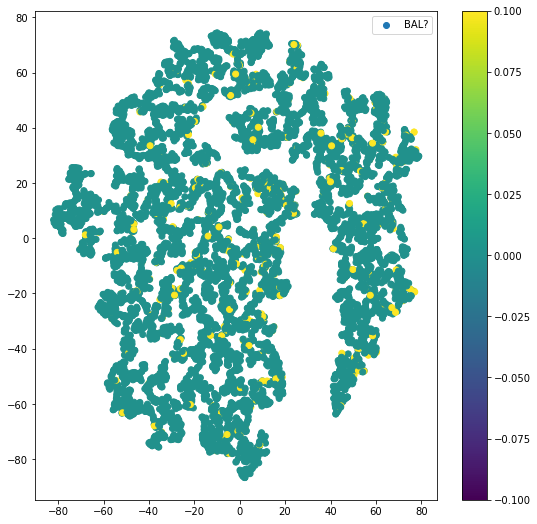

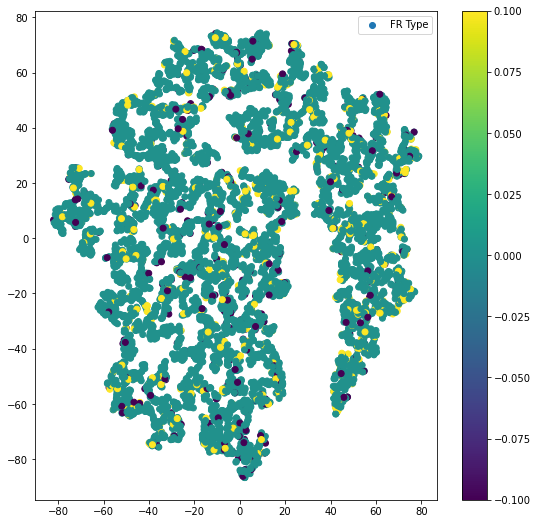

In [452]:
plotTSNE(dat[["LOGLBOL_1"]].values.flatten()[found.astype(int)], found.astype(int), "LOGLBOL")
plotTSNE(dat[["EW_CIV_1"]].values.flatten()[found.astype(int)], found.astype(int), "EW_CIV")
plotTSNE(dat[["VOFF_CIV_PEAK_1"]].values.flatten()[found.astype(int)], found.astype(int), "Blueshift")
plotTSNE(dat[["LOGEDD_RATIO_1"]].values.flatten()[found.astype(int)], found.astype(int), "Log Edd Ratio")
plotTSNE(dat[["E_BV_1"]].values.flatten()[found.astype(int)], found.astype(int), "E(B--V)")
plotTSNE(dat[["R_6CM_2500A_1"]].values.flatten()[found.astype(int)], found.astype(int), "R - radio")
plotTSNE(dat[["BAL_FLAG_1"]].values.flatten()[found.astype(int)], found.astype(int), "BAL?")
plotTSNE(dat[["FIRST_FR_TYPE_1"]].values.flatten()[found.astype(int)], found.astype(int), "FR Type")

Maybe objects with high Lbol like to hang in the upper right??

Do PCA and throw out some lower-significance components.  Then t-SNE again.

In [240]:
from sklearn.decomposition import PCA
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler

In [241]:
pipe = Pipeline([('scaler', StandardScaler()), #normalizing data
                ('reducer', PCA())])           #dimensionality reduction

pc = pipe.fit_transform(X_compressed)          #data goes here for processing

#Extracting useful metrics
var = pipe.steps[1][1].explained_variance_ratio_
var_sum = pipe.steps[1][1].explained_variance_ratio_.cumsum()

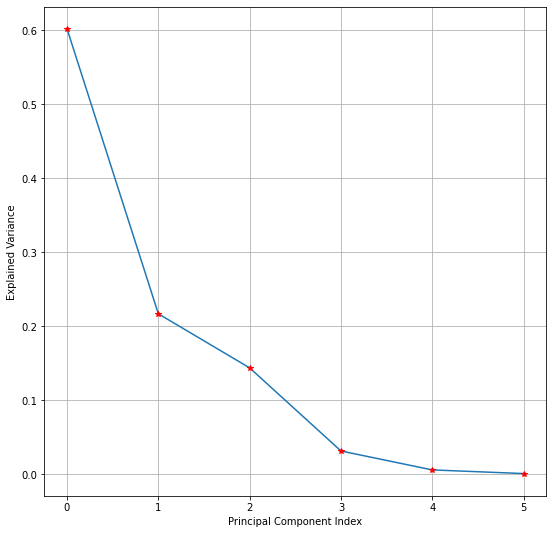

In [242]:
fig = plt.figure(figsize=(9,9))

plt.plot(var)
plt.plot(var,'r*')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

Did PCA order the features for me??  Maybe don't want this.

In [243]:
pc.shape

(8368, 6)

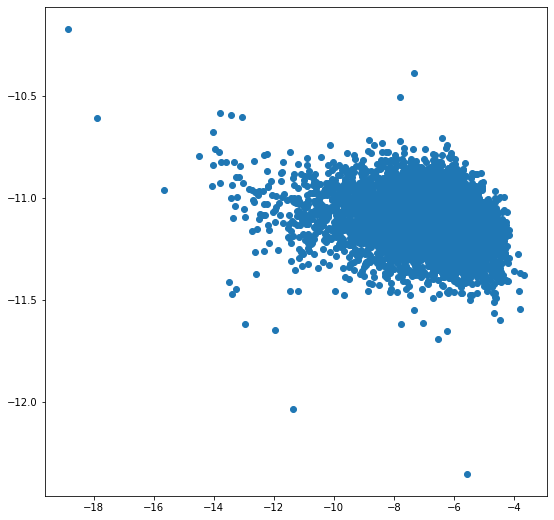

In [244]:
fig = plt.figure(figsize=(9,9))
plt.scatter(X_compressed[:,0], X_compressed[:,1])
plt.show()

In [245]:
pd.DataFrame(X_compressed)

0          1          2          3         4         5
0     -6.656836 -11.196295  12.583553  12.162502 -7.087040  6.898917
1     -6.275068 -11.077759  12.378908  11.746117 -7.091307  7.020844
2     -8.555177 -11.231456  12.935916  13.086589 -6.904900  7.032731
3     -6.229074 -11.075256  12.440562  11.865541 -7.106475  7.106423
4     -6.162354 -11.148499  12.569484  11.960955 -7.159302  7.061234
...         ...        ...        ...        ...       ...       ...
8363  -7.215397 -11.356267  12.884805  12.570259 -7.177102  6.961958
8364 -10.188086 -10.927982  13.153111  13.679558 -6.689930  7.547238
8365  -7.052799 -11.102357  12.601880  12.107822 -7.001111  7.384220
8366  -5.675612 -11.140435  12.463808  11.644338 -7.364016  7.089056
8367  -7.062914 -11.012358  12.600688  12.305864 -6.996708  7.069835

[8368 rows x 6 columns]

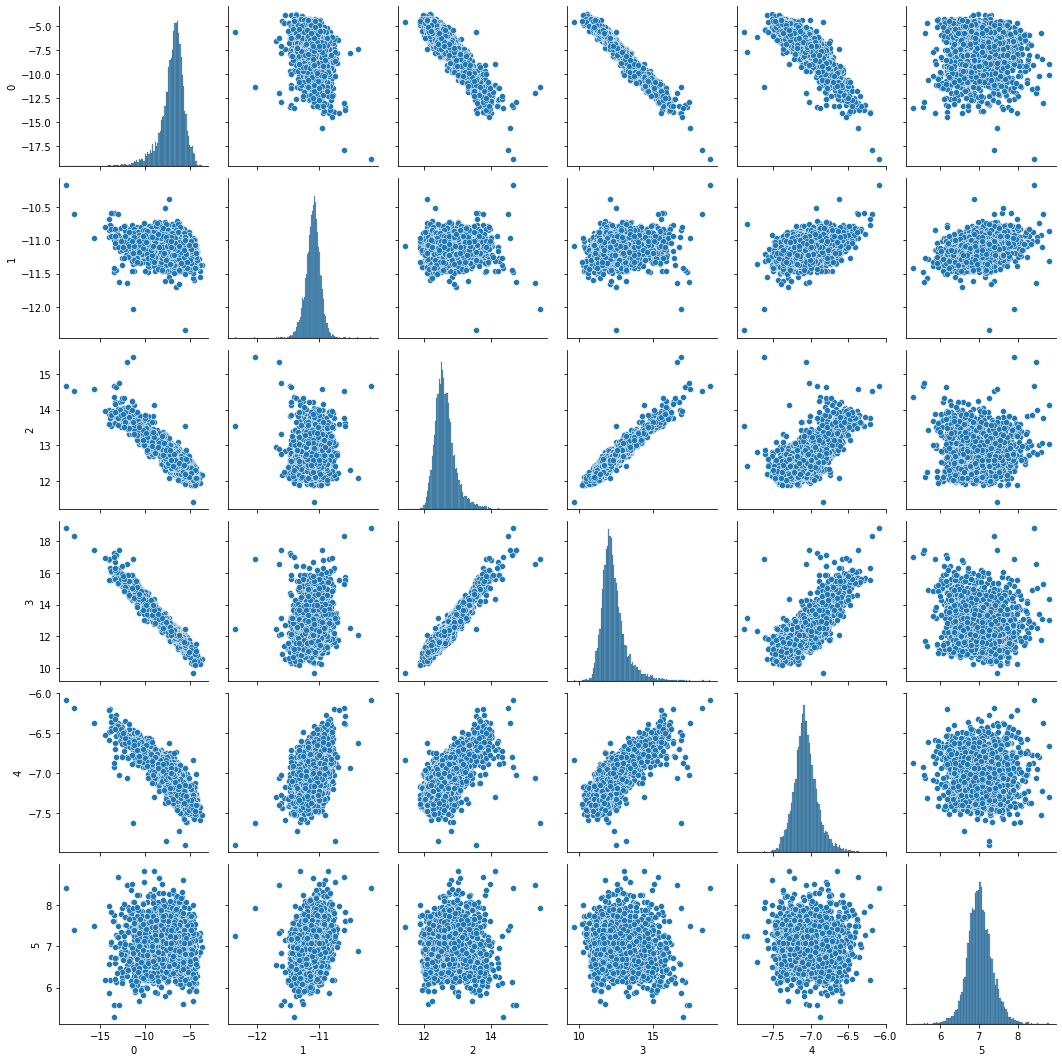

In [246]:
import seaborn

df = pd.DataFrame(X_compressed)

seaborn.pairplot(df)

---

Compute CIV EW and blueshift

In [464]:
X

array([[33.21803  , 33.921223 , 30.724604 , ..., 14.846318 , 13.317695 ,
        14.151351 ],
       [19.874874 , 20.790903 , 20.043615 , ...,  6.335633 ,  6.9407854,
         5.820573 ],
       [22.482862 , 23.138777 , 27.171658 , ..., 15.81914  , 15.413137 ,
        15.096482 ],
       ...,
       [14.459191 , 14.279158 , 14.267829 , ...,  7.5751047,  6.3564477,
         6.341022 ],
       [ 3.3154058,  6.9089637, 10.638741 , ...,  4.696215 ,  3.627235 ,
         6.040976 ],
       [ 7.4278784,  9.064822 ,  7.5617237, ...,  3.4098907,  4.9049726,
         3.3274734]], dtype=float32)

In [247]:
def get_CIV(wave, flux, reconstruction, name):
    #Going to save plots, but not show with magic above
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(wave, flux)
    ax.plot(wave, reconstruction, label="Autoencoder Reconstruction")
    ax.plot([1549.48,1549.48], [0.2*max(reconstruction), max(reconstruction)+2], "--k", label="Laboratory Wavelength - CIV")

    
    #Fit continuum
    cont1 = ((wave>=1445)&(wave<=1465))
    cont2 = ((wave>=1700)&(wave<=1705))
    ax.axvspan(1445, 1465, alpha=0.5, color='grey')
    ax.axvspan(1700, 1705, alpha=0.5, color='grey')

    m,b = np.polyfit(np.concatenate((wave[cont1], wave[cont2])), np.concatenate((reconstruction[cont1], reconstruction[cont2])), 1)
    continuum = wave*m + b
    ax.plot(wave, continuum, "-r", label="Power-law Continuum")\

    
    #Plot EW region under reconstruction
    EW = ((wave>=1500)&(wave<=1600))
    ax.fill_between(wave[EW], continuum[EW], reconstruction[EW], color="blue", alpha=0.2)

    #And compute the EW
    CIV_EW = 0
    ew_list = [0.]
    for i in range(len(wave[EW])):
        try:
            CIV_EW += ( (reconstruction[EW][i] - continuum[i]) / continuum[i] ) * ( wave[EW][i+1] - wave[EW][i] )
        except IndexError:
            CIV_EW += ( (reconstruction[EW][i] - continuum[i]) / continuum[i] ) * ( wave[EW][i] - wave[EW][i-1] )

        ew_list.append(CIV_EW)


    ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()
    CIV_blue = blueshift(wave[EW][ind_half_flux])
    ax.plot([wave[EW][ind_half_flux],wave[EW][ind_half_flux]], [0.2*max(reconstruction), max(reconstruction)+2], "--b", label="Observed Wavelength - Blue = %.2f km/s" % CIV_blue)

    ax.set_xlim(1435, 1710)
    ax.set_ylim(0.2*max(reconstruction), max(reconstruction)+2)
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig("/Users/Trevor1/Desktop/data/spectra/VLA_8403col_1.6z2.2/pngs_CIV/{}.png".format(name))
    #plt.show()
    
    return CIV_blue, CIV_EW

In [252]:
%%capture

reconstructions = stacked_ae.predict(X)
print("done reconstructions")

blue_list = []
ew_list   = []

for i in range(len(X)):
    civ_blue, civ_ew = get_CIV(wave[i], X[i], reconstructions[i], names[i])
    blue_list.append(civ_blue)
    ew_list.append(civ_ew)

KeyboardInterrupt: 

<ipython-input-261-1ba38184a159>:2: RuntimeWarning: invalid value encountered in log10
  ax.scatter(blue_list, np.log10(ew_list))


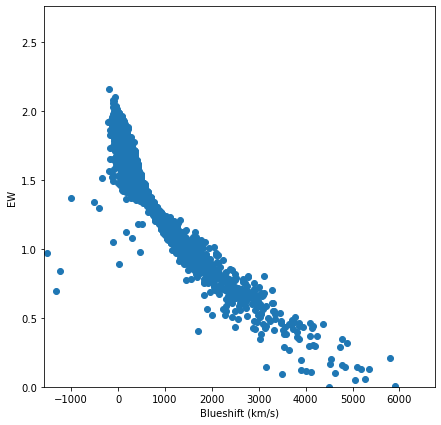

In [261]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(blue_list, np.log10(ew_list))
#ax.set_xlim(-500,5000)
ax.set_xlabel("Blueshift (km/s)")
ax.set_ylabel("EW")
#ax.set_yscale("log")
ax.set_xlim(-1577.0575829238915, 6752.935855052574)
ax.set_ylim(0.0, 2.762242337463174)
plt.show()

In [265]:
len(blue_list)

8368

In [268]:
len(dat.iloc[found])

8368

In [269]:
found

array([   0,    1,    2, ..., 8397, 8398, 8399])

In [275]:
np.array([np.array(dat.iloc[found]["name"])[np.array(blue_list)<-4000], np.array(blue_list)[np.array(blue_list)<-4000]]).T

array([['172858.16+603512.7', -5649.691184199695],
       ['135050.37+662910.6', -9231.230749590182],
       ['102214.76+021428.7', -6327.456050779935],
       ['103607.52+015659.0', -6625.699062649241],
       ['105704.19+030108.1', -6304.6724495879225],
       ['140821.66+025733.3', -6507.385050650054],
       ['142923.91+024023.1', -8373.040559877343],
       ['141927.49+044513.7', -5342.088933666452],
       ['150935.96+574300.5', -8648.570873877847],
       ['001741.87-105613.2', -6713.051956846002],
       ['003414.20-092738.7', -7179.950340194772],
       ['075551.44+352549.7', -7324.262237371567],
       ['152307.34+535358.2', -7909.309191632027],
       ['162501.98+430931.6', -8186.824798682457],
       ['090809.13+444138.8', -8118.804877281406],
       ['075331.84+270415.3', -5471.629305174152],
       ['103628.19+501157.8', -6033.44360386226],
       ['093217.06+415312.0', -8659.537254534582],
       ['103808.93+464249.2', -7137.9519384124],
       ['115757.24+505442.4', -59

Cell above never ended even though all the plots were done??  Fix this so I can actually save EW+blueshift!

In [496]:
CIV_data = np.array([blue_list, ew_list]).T
CIV_df   = pd.DataFrame(X_compressed, columns=["CIV_Blueshift_AE", "CIV_EW_AE"])
CIV_df.head()

(8368, 6)

---

Save a file with the latent parameters and reconstructions.

In [461]:
latent_params = pd.DataFrame(X_compressed, columns=["Latent{}".format(i) for i in range(1,7)])
latent_params.head()

Latent1    Latent2    Latent3    Latent4    Latent5     Latent6
0  10.995173 -24.321989 -86.158257 -23.353455 -23.098145  145.165146
1   3.507659 -15.365338 -41.509838  -8.665313 -19.529541   88.458229
2   2.539161  -4.128629 -97.612999 -20.272467  -3.241336  139.013672
3   4.729470 -16.875517 -40.656452 -10.279890 -16.192554   79.730820
4   6.467855 -15.585965 -41.874725 -15.720461 -12.612712   69.491760

In [462]:
sample_cut = dat.iloc[found]
sample_cut.shape

(8368, 65)

In [275]:
TSNE2 = pd.DataFrame(projTSNE2, columns=["TSNE_X", "TSNE_Y"])
TSNE2.head()

TSNE_X     TSNE_Y
0 -59.974598   5.428302
1  10.624625 -70.629379
2 -70.111412  -2.025018
3  24.048346 -53.701729
4  25.743031 -37.835445

In [276]:
df = pd.merge(sample_cut, latent_params, right_index=True, left_index=True)
df2= pd.merge(df, TSNE2, right_index=True, left_index=True)
df3= pd.merge(df2, CIV_df)
df2.head()

name        RA_1     Dec_1  REDSHIFT_1  PLATE_1  FIBER_1  \
0  095004.94-002012.2  147.520612 -0.336744      1.7756      267      275   
1  095938.28-003500.8  149.909527 -0.583571      1.8766      268       59   
2  101033.44-004724.5  152.639355 -0.790145      1.6675      270      213   
3  101100.92+002039.4  152.753859  0.344291      1.7487      270      491   
4  101826.85-000951.1  154.611911 -0.164201      1.8156      271      152   

   MJD_1  UNIFORM_TARGET_1    MI_Z2_1  LOGLBOL_1  ...  \
0  51608                 0 -27.635967  47.094489  ...   
1  51633                 0 -26.986037  46.849020  ...   
2  51909                 0 -27.539811  47.031922  ...   
3  51909                 0 -26.907112  46.713170  ...   
4  51883                 0 -27.177639  46.782514  ...   

                                         UGRIZ_DERED  DELTA_G_I    E_BV_2  \
0  (18.001000612974167, 17.926775991916656, 17.89...  -0.037049  0.069739   
1  (19.252000018954277, 18.74404826760292, 18.696...  -0.060394  0.035407   
2  (18.178000137209892, 18.07619148492813, 17.897...   0.209583  0.044319   
3  (18.662999659776688, 18.576296500861645, 18.58...  -0.121854  0.031931   
4  (18.50699943304062, 18.411264687776566, 18.418...  -0.134676  0.048818   

   Separation    Latent1     Latent2     Latent3    Latent4     TSNE_X  \
0    0.009446  47.630016  197.039566 -184.120697 -89.203102 -59.974598   
1    0.013102  36.250057  113.706329 -103.534317 -45.116665  10.624625   
2    0.012673  14.480593  204.195328 -176.934036 -88.136490 -70.111412   
3    0.005305  32.013721  105.890999  -96.678314 -44.374863  24.048346   
4    0.010948  27.914503   92.677177  -92.593033 -46.193886  25.743031   

      TSNE_Y  
0   5.428302  
1 -70.629379  
2  -2.025018  
3 -53.701729  
4 -37.835445  

[5 rows x 71 columns]

In [282]:
! ls ../../data/files/VLA2018b/

grdr7.8403col.radec.platemjdfiber.csv


In [283]:
df2.to_csv("grdr7.8403col.radec.platemjdfiber_w4LatentParams.csv")